<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Web Scraping Job Postings


## Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

   1. Determine the industry factors that are most important in predicting the salary amounts for these data.
   2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries. 

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer these two questions.

---

## Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to answer the two questions described above.

### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.


### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

---

## Requirements

1. Scrape and prepare your own data.

2. **Create and compare at least two models for each section**. One of the two models should be a decision tree or ensemble model. The other can be a classifier or regression of your choosing (e.g. Ridge, logistic regression, KNN, SVM, etc).
   - Section 1: Job Salary Trends
   - Section 2: Job Category Factors

3. Prepare a polished Jupyter Notebook with your analysis for a peer audience of data scientists. 
   - Make sure to clearly describe and label each section.
   - Comment on your code so that others could, in theory, replicate your work.

4. A brief writeup in an executive summary, written for a non-technical audience.
   - Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

#### BONUS

5. Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions.

6. Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

---

## Suggestions for Getting Started

1. Collect data from [Indeed.com](www.indeed.com) (or another aggregator) on data-related jobs to use in predicting salary trends for your analysis.
  - Select and parse data from *at least 1000 postings* for jobs, potentially from multiple location searches.
2. Find out what factors most directly impact salaries (e.g. title, location, department, etc).
  - Test, validate, and describe your models. What factors predict salary category? How do your models perform?
3. Discover which features have the greatest importance when determining a low vs. high paying job.
  - Your Boss is interested in what overall features hold the greatest significance.
  - HR is interested in which SKILLS and KEY WORDS hold the greatest significance.   
4. Author an executive summary that details the highlights of your analysis for a non-technical audience.
5. If tackling the bonus question, try framing the salary problem as a classification problem detecting low vs. high salary positions.

---

## Useful Resources

- Scraping is one of the most fun, useful and interesting skills out there. Don’t lose out by copying someone else's code!
- [Here is some advice on how to write for a non-technical audience](http://programmers.stackexchange.com/questions/11523/explaining-technical-things-to-non-technical-people)
- [Documentation for BeautifulSoup can be found here](http://www.crummy.com/software/BeautifulSoup/).

---

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word

from collections import Counter
import string
import re


%matplotlib inline

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


<font color="DarkSlateBlue">
## Sections<br>
- [Preprocessing](#preprocess)
    - [Data Wrangling](#data_wrangling)
- [Section 1 - Salary Trends](#salary_trends)
    - [Exploratory Data Analysis and Feature Engineering](#salary_trends_eda_fe)
      - [Split into training and test sets](#salary_trends_split_train_test)
      - [Engineer the High/Low Salary Class feature](#salary_trends_engineer_salary_class)
      - [Engineer NLP features](#salary_trends_engineer_NLP)
    - [Train and Test](#salary_trends_train_test)
      - [Prepare models: Random Forest, SGD Classifer with L1 Penalty, SGD Classifier with Elastic Net Penalty](#salary_trends_prep_models)
      - [Train and Test on Job Industry and Job Seniority](#salary_trends_train_test_ji_js)
      - [Train and Test on Job Titles](#salary_trends_train_test_jt)
      - [Train and Test on Job Description](#salary_trends_train_test_jd)
      - [Train and Test on Job Requirements](#salary_trends_train_test_jr)
      - [Train and Test on all features](#salary_trends_train_test_all)
      - [Plot ROC curve on best model](#salary_trends_roc_curve)
- [Section 2 - Job Category Factors](#job_category_factors)
    - [Train and Test on all features except Job Title](#job_category_factors_train_test)
- [Executive Summary](#executive_summary)

<a id='preprocess_data'/>
## Preprocessing

<a id='data_wrangling'/>
### Data Wrangling

In [3]:
# read in the dataset
df = pd.read_csv('./datasets/jobs2018311700.csv')

#### A broad look

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612 entries, 0 to 1611
Data columns (total 13 columns):
Unnamed: 0               1604 non-null float64
job_title                1612 non-null object
job_company              1612 non-null object
job_location             1551 non-null object
job_seniority            1585 non-null object
job_category             1612 non-null object
job_employment_type      1612 non-null object
job_salary_range_from    1485 non-null object
job_salary_range_to      1485 non-null object
job_salary_type          1485 non-null object
job_details_url          1612 non-null object
job_description          1611 non-null object
job_requirements         1551 non-null object
dtypes: float64(1), object(12)
memory usage: 163.8+ KB


In [4]:
# for career switchers, some job categories are more like industry...rename so that we do not confuse ourselves
# with job category in the question
df.rename(columns={'job_category':'job_industry'},inplace=True)

In [5]:
# drop duplicates
df.drop_duplicates(subset=['job_title','job_company','job_location','job_industry'], keep='first', inplace=True)
df.drop(columns='Unnamed: 0',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057 entries, 0 to 1611
Data columns (total 12 columns):
job_title                1057 non-null object
job_company              1057 non-null object
job_location             1018 non-null object
job_seniority            1040 non-null object
job_industry             1057 non-null object
job_employment_type      1057 non-null object
job_salary_range_from    965 non-null object
job_salary_range_to      965 non-null object
job_salary_type          965 non-null object
job_details_url          1057 non-null object
job_description          1056 non-null object
job_requirements         1018 non-null object
dtypes: object(12)
memory usage: 107.4+ KB


In [6]:
# drop rows that have null salary
df = df.dropna(subset=['job_salary_type'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 965 entries, 0 to 1611
Data columns (total 12 columns):
job_title                965 non-null object
job_company              965 non-null object
job_location             954 non-null object
job_seniority            961 non-null object
job_industry             965 non-null object
job_employment_type      965 non-null object
job_salary_range_from    965 non-null object
job_salary_range_to      965 non-null object
job_salary_type          965 non-null object
job_details_url          965 non-null object
job_description          964 non-null object
job_requirements         954 non-null object
dtypes: object(12)
memory usage: 98.0+ KB


In [7]:
# drop rows which were headers when I concatebated multiple files of scraped data 
df.drop(index=(df[df['job_location']=='job_location'].index),inplace=True)
df.shape

(964, 12)

In [8]:
# Take a quick look at rows where any values are null
df[df.isnull().any(axis=1)]
# Let's handle nulls as part of reviewing each feature

,job_title,job_company,job_location,job_seniority,job_industry,job_employment_type,job_salary_range_from,job_salary_range_to,job_salary_type,job_details_url,job_description,job_requirements
54,Lecturer - IT Applications Development,Institute of Technical Education,NaN,Executive,Education and Training ...,Contract,"$3,000","$6,000",Monthly,https://www.mycareersfuture.sg/job/lecturer-ap...,<p><strong>Responsibilities</strong><br> <br>A...,NaN
67,"Assistant Manager, GeoAnalytics",Singapore Land Authority,NaN,Middle Management,Information Technology ...,Full Time,"$3,500","$6,800",Monthly,https://www.mycareersfuture.sg/job/assistant-m...,"<p><strong>Assistant Manager, GeoAnalytics</st...",NaN
68,"Assistant Manager / Technical Manager, GeoSpa...",Singapore Land Authority,NaN,Middle Management,Information Technology ...,Full Time,"$4,000","$6,800",Monthly,https://www.mycareersfuture.sg/job/assistant-m...,<p><strong>Assistant Manager/ Technical Manage...,NaN
204,Strategic Account Executive,TALEND SINGAPORE PTE. LTD.,NaN,Executive,Sales / Retail,Permanent,"$140,000","$250,000",Annually,https://www.mycareersfuture.sg/job/strategic-a...,<p><strong>Strategic Account Executive (Malays...,<p>Talend is hiring a results driven Account E...
842,Data Analyst - Data Transformation IMO,ROBERT WALTERS (SINGAPORE) PTE LTD,Central,Executive,Information Technology,Temporary ...,"$6,000","$7,400",Monthly,https://www.mycareersfuture.sg/job/data-analys...,NaN,NaN
930,"Senior Executive, Data Services",Singapore Land Authority,NaN,Fresh/entry level,Information Technology ...,Contract,"$2,800","$5,600",Monthly,https://www.mycareersfuture.sg/job/senior-exec...,"<p><strong>Senior Executive, Data Services</st...",NaN
959,"Senior Executive, Data Management",Singapore Land Authority,NaN,Executive,Information Technology ...,Contract,"$2,800","$5,600",Monthly,https://www.mycareersfuture.sg/job/senior-exec...,"<p><strong>Senior Executive, Data Management</...",NaN
1159,Office of Information Services - Manager / D...,Republic Polytechnic,NaN,NaN,Education and Training ...,Full Time,"$4,200","$7,300",Monthly,https://www.mycareersfuture.sg/job/office-info...,<p><strong>Job Responsibilities</strong><br>- ...,NaN
1350,"Senior / Principal Researcher, Underground Geo...",Singapore Land Authority,NaN,Executive,Information Technology ...,Full Time,"$2,800","$5,600",Monthly,https://www.mycareersfuture.sg/job/senior-prin...,"<p><strong>Senior/Principal Researcher, Underg...",NaN
1399,Engineer (Complex Systems Modelling),Housing and Development Board,NaN,NaN,Public / Civil Service,Contract,"$2,400","$8,555",Monthly,https://www.mycareersfuture.sg/job/engineer-ho...,<p> </p><p><strong>Responsibilities</strong></...,NaN


In [9]:
df.drop([1,25,85,86,233,1373], inplace=True)

<a id='clean_data_job_title'/>
#### Let's examine job_title

In [10]:
# Let's take a quick look

df['job_title'].value_counts()

# A quick look reveals there are several jobs like 'Electronic Engineer' and 'Frontend Developer' that look non-data related. 
# Manually eyeball and job description and decide whether to drop.

Business Analyst                                                                                  58
Data Scientist                                                                                    39
Data Engineer                                                                                     23
Data Analyst                                                                                      20
Senior Business Analyst                                                                           19
Senior Data Scientist                                                                              6
Information Technology Business Analyst                                                            5
Research Fellow                                                                                    5
IT Business Analyst                                                                                5
Salesforce Business Analyst                                                                

In [11]:
# Fish out potentially irrelevant jobs by fishy words in job titles e.g. 'UX'
# The quick review reveals some non-relevant jobs. 
# This is NOT an exhaustive look just trim where we spot something
df[df['job_title'].str.lower().str.contains('|'.join(['ui ','ux ',' design','engagement']))]

,job_title,job_company,job_location,job_seniority,job_industry,job_employment_type,job_salary_range_from,job_salary_range_to,job_salary_type,job_details_url,job_description,job_requirements
91,Informatica and Cognos Solution Designer,SANDBOX CONSULTING PTE. LTD.,Islandwide,Senior Management ...,Information Technology,Permanent ...,"$7,000","$7,500",Monthly,https://www.mycareersfuture.sg/job/informatica...,<p>· Total Experience of 8 to 11 years...,<p>· Total Experience of 8 to 11 years...
254,Information Designer,IBM GLOBAL SERVICES PTE. LTD.,Central,Professional,Information Technology,Permanent,"$3,500","$5,500",Monthly,https://www.mycareersfuture.sg/job/information...,"<p><strong>Graphics, Video and Multimedia Desi...",<ul> <li>Work proactively within Quote to Cas...
492,INFORMATION TECHNOLOGY PROJECT MANAGER - ENGAG...,PALO IT SINGAPORE PTE. LTD.,Central,Manager,Information Technology,Full Time,"$7,000","$14,000",Monthly,https://www.mycareersfuture.sg/job/information...,<p>About us</p><p>PALO IT is an innovation &am...,<ul> \t<li>Have a good understanding of Scrum ...
1377,ENGAGEMENT MANAGER,AXA TECHNOLOGY SERVICES ASIA PTE. LTD.,Central,Senior Management,Information Technology,Permanent,"$8,000","$12,000",Monthly,https://www.mycareersfuture.sg/job/engagement-...,<p><strong>Date : </strong>23/10/2018</p><p><s...,<p>CANDIDATE PROFILE</p><p> </p><p><u>Technica...


In [12]:
# expression to remove brackets starting with numbers e.g. (180004IM) and punctuation
df['job_title'] = df['job_title'].str.replace('\([0-9]\w*\)|[%s] % re.escape(string.punctuation)', '').str.strip(' ')
df['job_title'].value_counts()

Business Analyst                                                                               58
Data Scientist                                                                                 39
Data Engineer                                                                                  23
Data Analyst                                                                                   21
Senior Business Analyst                                                                        19
Senior Data Scientist                                                                           6
IT Business Analyst                                                                             5
Information Technology Business Analyst                                                         5
Research Fellow                                                                                 5
Business Intelligence Analyst                                                                   4
Research Engineer   

<a id='clean_data_job_company'/>
#### Let's clean job_company

In [13]:
df['job_company'].unique()

array(['JPMORGAN CHASE BANK, N.A.', 'GOOGLE ASIA PACIFIC PTE. LTD.',
       'A*STAR RESEARCH ENTITIES', 'PALM 3 ASIA PTE. LTD.',
       'Company Undisclosed', 'INVOSYSTEMS SOLUTIONS PTE. LTD.',
       'DBS BANK LTD.', 'AIA SINGAPORE PRIVATE LIMITED',
       'ASPENTECH PTE. LTD.', 'ASIACLOUD SOLUTIONS PRIVATE LIMITED',
       'TALEND SINGAPORE PTE. LTD.', '6ESTATES PTE. LTD.',
       'IOTALENTS PTE. LTD.', 'APPLE SOUTH ASIA PTE. LTD.',
       'TERALYTICS PTE. LTD.', 'LIE XIAN PTE. LTD.',
       'ORACLE CAPAC SERVICES UNLIMITED COMPANY (SINGAPORE BRANCH)',
       'SKYSCANNER PRIVATE LIMITED', 'SCHELLDEN GLOBAL PTE. LTD.',
       'Institute of Technical Education', 'PALO IT SINGAPORE PTE. LTD.',
       'CLOUDSTREAM ASIA PACIFIC PTE. LTD.',
       'OVERSEA-CHINESE BANKING CORPORATION LIMITED',
       'COGNIZANT TECHNOLOGY SOLUTIONS ASIA PACIFIC PTE. LTD.',
       'VISA WORLDWIDE PTE. LIMITED',
       'CHARLES & KEITH (SINGAPORE) PTE. LTD.',
       'Singapore Land Authority', 'SIEMENS MOBIL

In [14]:
# nothing much to clean

<a id='clean_data_job_location'/>
#### Let's clean job_location

In [15]:
df['job_location'].unique()

array(['East, Central', 'South', 'West', 'East', 'Central', 'Islandwide',
       nan, 'North', 'North, Central', 'North, East, Central',
       'South, West', 'South, Central', 'South, East, Central'],
      dtype=object)

In [16]:
# drop the strategic account executive role as on closer reading the location is in 
df.drop(204,axis=0,inplace=True)

In [17]:
# Check for any more job titles that include 'account' - could be pure sales roles
df[df['job_title'].str.lower().str.contains('account')]
# below looks alright - primarily technical responsibilities, let's retain the jobs

,job_title,job_company,job_location,job_seniority,job_industry,job_employment_type,job_salary_range_from,job_salary_range_to,job_salary_type,job_details_url,job_description,job_requirements
2,"Technical Account Manager, Google Cloud Profes...",GOOGLE ASIA PACIFIC PTE. LTD.,South,Executive,Engineering,Full Time,"$7,750","$15,500",Monthly,https://www.mycareersfuture.sg/job/technical-a...,<p><strong>Company overview:</strong></p><p>Go...,<p><strong>Minimum qualifications:</strong></p...
507,"Enterprise Applications Lead (BA, PM - Interna...",DAVID & GOLIATH PTE. LTD.,Central,Middle Management,Information Technology,Permanent ...,"$6,250","$12,500",Monthly,https://www.mycareersfuture.sg/job/enterprise-...,"<p>Enterprise Applications Lead (BA, PM - Inte...",<p><strong><em>In return for this excellent ca...


In [18]:
# Null Job Locations 
# Fill in the missing job_location after manually checking the job address via the url
df.loc[[54,1159,1605],'job_location'] = 'North'
df.loc[[1399,1436],'job_location'] = 'North, Central'
df.loc[[67,68,842,930,959,1350],['job_location']] = 'Central'

# check any nulls left
df[['job_location']].isnull().any()

job_location    False
dtype: bool

<a id='clean_data_job_seniority'/>
#### Let's clean job_seniority

In [19]:
df['job_seniority'].value_counts()

Professional             279
Executive                182
Senior Executive         121
Manager                   84
Middle Management         50
Non-executive             44
Junior Executive          32
Professional ...          31
Senior Management         28
Executive ...             25
Fresh/entry level         20
Manager ...               20
Senior Management ...     13
Middle Management ...     13
Fresh/entry level ...      9
Junior Executive ...       1
Non-executive ...          1
Name: job_seniority, dtype: int64

In [20]:
remove_punctuation_table = str.maketrans('','',string.punctuation)

# remove punctuation and strip ' '
df['job_seniority'] = df['job_seniority'].str.translate(remove_punctuation_table).str.strip(' ')
df['job_seniority'].value_counts()

Professional         310
Executive            207
Senior Executive     121
Manager              104
Middle Management     63
Nonexecutive          45
Senior Management     41
Junior Executive      33
Freshentry level      29
Name: job_seniority, dtype: int64

In [21]:
df[df['job_seniority'].isnull()]

,job_title,job_company,job_location,job_seniority,job_industry,job_employment_type,job_salary_range_from,job_salary_range_to,job_salary_type,job_details_url,job_description,job_requirements
1159,Office of Information Services - Manager / D...,Republic Polytechnic,North,NaN,Education and Training ...,Full Time,"$4,200","$7,300",Monthly,https://www.mycareersfuture.sg/job/office-info...,<p><strong>Job Responsibilities</strong><br>- ...,NaN
1399,Engineer (Complex Systems Modelling),Housing and Development Board,"North, Central",NaN,Public / Civil Service,Contract,"$2,400","$8,555",Monthly,https://www.mycareersfuture.sg/job/engineer-ho...,<p> </p><p><strong>Responsibilities</strong></...,NaN
1436,Engineer (Analytics),Housing and Development Board,"North, Central",NaN,Public / Civil Service,Contract,"$2,400","$8,555",Monthly,https://www.mycareersfuture.sg/job/engineer-ho...,<p> </p><p><strong>Responsibilities </strong><...,NaN
1605,School of Infocomm - Research Staff (Data Anal...,Republic Polytechnic,North,NaN,Education and Training ...,Contract,"$3,100","$5,300",Monthly,https://www.mycareersfuture.sg/job/school-info...,<p><strong>Job Responsibilities</strong><br> W...,NaN


In [22]:
# drop these
df.drop(df[df['job_seniority'].isnull()].index,inplace=True)

<a id='clean_data_job_industry'/>
#### Let's clean job_industry

In [23]:
df['job_industry'].value_counts()

Information Technology                  462
Banking and Finance                     116
Sciences / Laboratory / R&D              60
Engineering ...                          48
Engineering                              39
Information Technology ...               28
Banking and Finance ...                  25
Consulting  ...                          24
Others                                   24
Consulting                               22
Marketing / Public Relations              9
Accounting / Auditing / Taxation          8
Insurance                                 8
Education and Training                    7
Advertising / Media                       7
Sales / Retail                            7
Healthcare / Pharmaceutical               6
Accounting / Auditing / Taxation ...      6
Logistics / Supply Chain                  5
Human Resources                           5
Professional Services                     5
Education and Training ...                4
General Management ...          

In [24]:
# looks fishy; after examining let's drop
df[df['job_industry']=='Admin / Secretarial ...']

,job_title,job_company,job_location,job_seniority,job_industry,job_employment_type,job_salary_range_from,job_salary_range_to,job_salary_type,job_details_url,job_description,job_requirements
1101,Senior / Research Consultant (Recruitment),RGF TALENT SOLUTIONS SINGAPORE PTE. LTD.,Central,Nonexecutive,Admin / Secretarial ...,Full Time,"$3,000","$5,000",Monthly,https://www.mycareersfuture.sg/job/senior-rese...,<p>The purpose of a RGF Research Consultant is...,<ul> <li>You will have some experience in re...


In [25]:
df.drop(df[df['job_industry']=='Admin / Secretarial ...'].index,inplace=True)

In [26]:
# remove punctuation and strip ' '
df['job_industry'] = df['job_industry'].str.translate(remove_punctuation_table).str.strip(' ')
df['job_industry'].head()

0      Information Technology
2                 Engineering
3    Sciences  Laboratory  RD
4    Sciences  Laboratory  RD
5          Advertising  Media
Name: job_industry, dtype: object

<a id='clean_data_job_employment_type'/>
#### Let's clean job_employment_type

In [27]:
df['job_employment_type'].value_counts()

Full Time        307
Permanent ...    211
Permanent        183
Contract ...     131
Contract         115
Internship         2
Freelance ...      1
Full Time ...      1
Temporary ...      1
Name: job_employment_type, dtype: int64

In [28]:
remove_punctuation_table = str.maketrans('','',string.punctuation)

# Remove the '...  from job employment type
df['job_employment_type'] = df['job_employment_type'].str.translate(remove_punctuation_table).str.strip(' ')

In [29]:
df['job_employment_type'].value_counts()

Permanent     394
Full Time     308
Contract      246
Internship      2
Freelance       1
Temporary       1
Name: job_employment_type, dtype: int64

<a id='clean_data_job_salary'/>
#### Let's clean job salary columns

In [30]:
df['job_salary_range_to'].head()

0    $12,000
2    $15,500
3     $9,000
4     $5,000
5     $4,800
Name: job_salary_range_to, dtype: object

In [31]:
# Convert into float
remove_curr_symbols_table = str.maketrans('','','$,')

df['job_salary_range_from'] = df['job_salary_range_from'].str.translate(remove_curr_symbols_table).astype(float)
df['job_salary_range_to'] = df['job_salary_range_to'].str.translate(remove_curr_symbols_table).astype(float)

In [32]:
df['job_salary_range_to'].head()

0    12000.0
2    15500.0
3     9000.0
4     5000.0
5     4800.0
Name: job_salary_range_to, dtype: float64

In [33]:
df['job_salary_type'].value_counts()

Monthly     918
Annually     34
Name: job_salary_type, dtype: int64

<a id='clean_data_job_description_requirements'/>
#### Let's clean job requirements and description columns

In [34]:
df['job_description'].head(5)

0    <p>JPMorgan Chase &amp; Co. (NYSE: JPM) is a l...
2    <p><strong>Company overview:</strong></p><p>Go...
3    <p>We are looking for creative and highly moti...
4    <ul>   <li>Implementation of building control ...
5    <p><strong><u>About Asia Finance </u></strong>...
Name: job_description, dtype: object

In [35]:
# some job description have the job title appearing in job description due to scraping, correct this
for i,row in df.iterrows():
    d = str(row['job_description']).lower()
    t = row['job_title'].lower()
    df.loc[i,'job_description'] = d.replace(t,'')

In [36]:
# some rows have job requirements that are null, as they are embedded in job description
for i,row in df[df['job_requirements'].isnull()].iterrows():    
    r = str(row['job_description']).lower().split('requirements')
    print('row {}'.format(i))
    if (len(r) > 1):
        print(r[1])
        print('\n')
    else:     
        print('*** Unable to find job requirements in job description. ***\n')

row 54
</strong></p><div> <p><strong>college central </strong></p> <p>you should be trained in information technology, computer science or software engineering, with at least 3 years of relevant work experience in web/mobile applications development, content management system or it related field.</p> <p>you should be competent with adobe cc applications and have good programming skills in ios programming (swift), c#, php, html5, css, javascript, python. candidates with experience and/or it certifications in areas of data analytics, internet of things (iot), or artificial intelligence (ai) and machine learning (ml) will have an advantage</p> <p><strong>college east</strong></p> <p>you should be trained in information technology, computer science, data science and/or analytics, with at least 3 years of relevant work experience to be able to develop students' skills in implementing iot/software applications, including data analytics solutions.</p> <div>you should possess relevant experien

In [37]:
# Drop rows that does not have job requirements after examining the above
df.drop([842,959,930],inplace=True)

In [38]:
# move any job_requirements that were lumped into job_description during scraping
for i,row in df[df['job_requirements'].isnull()].iterrows():
    r = str(row['job_description']).lower().split('requirements')
    if (len(r) > 1):
        df.loc[i,'job_description'] = r[0]
        df.loc[i,'job_requirements'] = r[1]

In [39]:
df['job_requirements'].isnull().any()

False

In [40]:
df['job_requirements'].head(5)

0    <p>This role requires a wide variety of streng...
2    <p><strong>Minimum qualifications:</strong></p...
3    <ul> \t<li>Ph.D in a quantitative field, stron...
4    <ul>   <li>Bachelor or Masters in Engineering ...
5    <ul> \t<li>Relevant Bachelor’s degree in Engli...
Name: job_requirements, dtype: object

In [41]:
# Remove html tags from job description
expr_html_tag = re.compile('<.*?>|&amp;')

df['job_description'] = df['job_description'].str.replace(expr_html_tag, ' ').str.strip(' ')
df['job_description'].head(5)

0    jpmorgan chase   co. (nyse: jpm) is a leading ...
2    company overview:   google is not a convention...
3    we are looking for creative and highly motivat...
4    implementation of building control and automat...
5    about asia finance     asia finance is a unifi...
Name: job_description, dtype: object

In [42]:
df['job_requirements'] = df['job_requirements'].str.replace(expr_html_tag, ' ').str.strip(' ')
df['job_requirements'].head(5)

0    This role requires a wide variety of strengths...
2    Minimum qualifications:   - 3 years of experie...
3    \t Ph.D in a quantitative field, strong mathem...
4    Bachelor or Masters in Engineering (Electrical...
5    \t Relevant Bachelor’s degree in English, jour...
Name: job_requirements, dtype: object

In [43]:
# at the end of cleaning, verify again no values are null
df.isnull().any()

job_title                False
job_company              False
job_location             False
job_seniority            False
job_industry             False
job_employment_type      False
job_salary_range_from    False
job_salary_range_to      False
job_salary_type          False
job_details_url          False
job_description          False
job_requirements         False
dtype: bool

In [44]:
df.shape

(949, 12)

In [45]:
#df.job_requirements.str.findall('(\w) year[s*] experience \w.*', flags=re.IGNORECASE)

In [46]:
df = df.reset_index(drop=True)
df.index.values[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

<a id='salary_trends'/>
## Section 1 Salary Trends

<a id='eda_fe'/>
### Salary Trends: Exploratory Data Analysis and Feature Engineering

#### Now we want to create our target column - salary - using the salary range.

In [47]:
# Engineer an average monthly salary
def engineer_monthly_salary_avg(row):
    if row['job_salary_type']=='Annually':
        return (row['job_salary_range_to'] + row['job_salary_range_from']) / (12 * 2)
    else:
        return (row['job_salary_range_to'] + row['job_salary_range_from']) / 2
        
df['monthly_salary_avg'] = df.apply(engineer_monthly_salary_avg, axis=1)

In [48]:
df[[col for col in df.columns.values if 'salary' in col]].sample(10)

,job_salary_range_from,job_salary_range_to,job_salary_type,monthly_salary_avg
848,6000.0,9000.0,Monthly,7500.0
94,8500.0,12000.0,Monthly,10250.0
940,6000.0,11000.0,Monthly,8500.0
640,5000.0,7000.0,Monthly,6000.0
662,24000.0,45000.0,Annually,2875.0
67,4000.0,9000.0,Monthly,6500.0
766,7000.0,11000.0,Monthly,9000.0
685,3000.0,5000.0,Monthly,4000.0
164,3400.0,6800.0,Monthly,5100.0
453,4000.0,7500.0,Monthly,5750.0


<a id='salary_trends_split_train_test'/>
#### Split into training and test sets
At this point we are not ready for training and testing the models yet; we are splitting to make sure we do EDA or imputation ONLY from train set, to avoid overfitting.

In [49]:
# train test split
df_train, df_test, y_train, y_test = train_test_split(df, df['monthly_salary_avg'], test_size=0.25)

# Get hold of indices for train set and test sets
df_train_indices = df_train.index
df_test_indices = df_test.index

Text(0.5,0,'Average Monthly Salary')

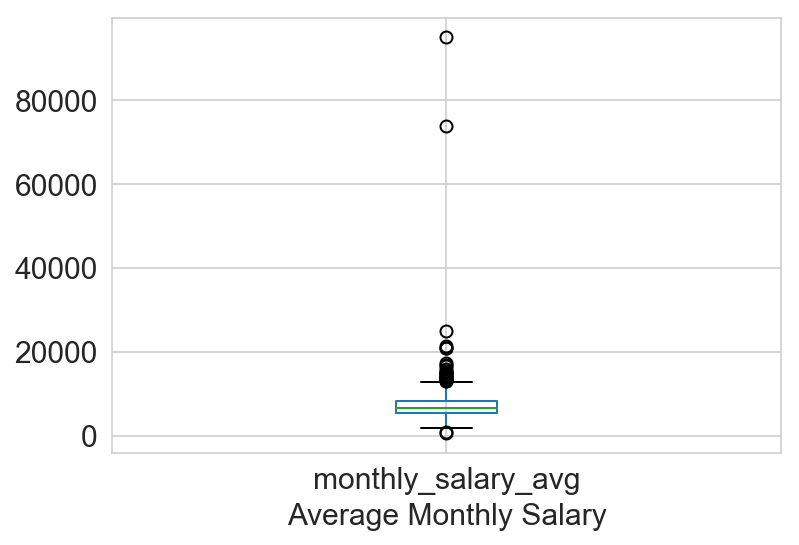

In [50]:
_ = df_train.boxplot('monthly_salary_avg',fontsize=15,labels=['Average Monthly Salary'])
plt.xlabel('Average Monthly Salary',fontsize=15)
# Lots of outliers

In [51]:
df_train[['monthly_salary_avg']].describe()

,monthly_salary_avg
count,711.000000
mean,7432.898969
std,4968.100010
min,800.500000
25%,5500.000000
50%,6750.000000
75%,8500.000000
max,95000.000000


In [52]:
# Get the outliers
percentile_25,percentile_75 = np.percentile(df_train['monthly_salary_avg'], [25, 75])
iqr = percentile_75 - percentile_25
lower_limit = percentile_25 - iqr
upper_limit = percentile_75 + iqr

print(lower_limit)
print(upper_limit)
df_train_outliers = df_train[(df_train['monthly_salary_avg'] < lower_limit) | (df_train['monthly_salary_avg'] > upper_limit)]
df_train_outliers

# Potentially drop these outliers during iteration of models

2500.0
11500.0


,job_title,job_company,job_location,job_seniority,job_industry,job_employment_type,job_salary_range_from,job_salary_range_to,job_salary_type,job_details_url,job_description,job_requirements,monthly_salary_avg
302,APAC CRO Credit Risk Management Business Analy...,CREDIT SUISSE SERVICES AG,Central,Senior Executive,Banking and Finance,Permanent,9000.0,15000.0,Monthly,https://www.mycareersfuture.sg/job/apac-cro-cr...,credit suisse company overview credit suisse...,You Offer... \t You have a Bachelor's Degre...,12000.000000
915,APAC Regional Marketing Manager,ELEMENT AI INC. PTE. LTD.,Central,Manager,Marketing Public Relations,Permanent,12500.0,17500.0,Monthly,https://www.mycareersfuture.sg/job/apac-region...,- singapore element ai is one of the world’...,What you'll do: Brand \t Manage and coor...,15000.000000
665,"VP, Data Scientist, Business Analytics, Consum...",DBS BANK LTD.,Central,Manager,Banking and Finance,Full Time,9500.0,18000.0,Monthly,https://www.mycareersfuture.sg/job/vp-data-sci...,work with product and business teams to define...,"PhD in computer science, statistics, or other ...",13750.000000
874,Head of Integrated Campaigns and Strategic Eve...,GOOGLE ASIA PACIFIC PTE. LTD.,South,Senior Management,Marketing Public Relations,Full Time,14045.0,28090.0,Monthly,https://www.mycareersfuture.sg/job/head-integr...,company overview: google is not a convention...,Minimum qualifications: - Bachelor's degree ...,21067.500000
553,Partner - Compensation and People Sciences,AMAZON ASIA-PACIFIC RESOURCES PRIVATE LIMITED,Central,Manager,Human Resources,Permanent,11000.0,15000.0,Monthly,https://www.mycareersfuture.sg/job/partner-com...,does the challenge and ownership that comes fr...,\t Compiling and evaluating quantitative and q...,13000.000000
400,"Vice President, Business Analyst",Company Undisclosed,Central,Senior Management,Banking and Finance,Full Time,13500.0,14500.0,Monthly,https://www.mycareersfuture.sg/job/vice-presid...,"\t elicit requirement, prioritise and analyse ...",\t Bachelor Degree in related field or equival...,14000.000000
220,Nielsen FastForward Internship Jan - Jun 2019,THE NIELSEN COMPANY (SINGAPORE) PTE. LTD.,Central,Freshentry level,Consulting,Full Time,800.0,801.0,Monthly,https://www.mycareersfuture.sg/job/nielsen-fas...,how to apply: click this link https://goo.gl/f...,HOW TO APPLY: CLICK THIS LINK https://goo.gl/f...,800.500000
668,Data Analyst (Intern),SHIPSFOCUS INTELLIGENCE PTE. LTD.,South,Freshentry level,Logistics Supply Chain,Internship,800.0,1000.0,Monthly,https://www.mycareersfuture.sg/job/data-analys...,a passionate person? have good skills and grea...,You are likely to have been trained and have: ...,900.000000
706,"Vice President, Data Engineering",LAZADA SERVICES SOUTH EAST ASIA PTE. LTD.,Central,Senior Management,Information Technology,Permanent,13000.0,17000.0,Monthly,https://www.mycareersfuture.sg/job/vice-presid...,"story of lazada group: launched in 2012, laz...",\t \t Minimum 5 years of data engineering exp...,15000.000000
777,Senior Data Scientist,SHOPEE SINGAPORE PRIVATE LIMITED,South,Executive,Information Technology,Permanent,9000.0,17600.0,Monthly,https://www.mycareersfuture.sg/job/senior-data...,develop and enhance data infrastructure using ...,Minimum B.S. degree in Computer Science or a r...,13300.000000


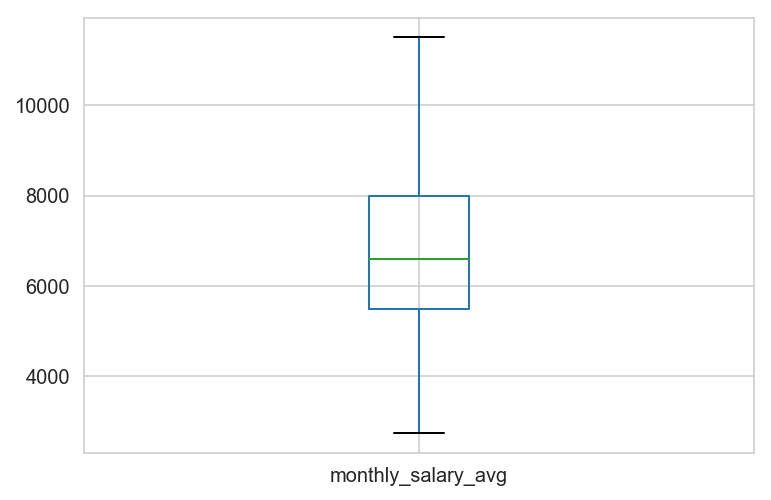

In [53]:
# If we drop the outliers, 
df_train.loc[[i for i in df_train.index if i not in df_train_outliers.index]][['monthly_salary_avg']].boxplot()

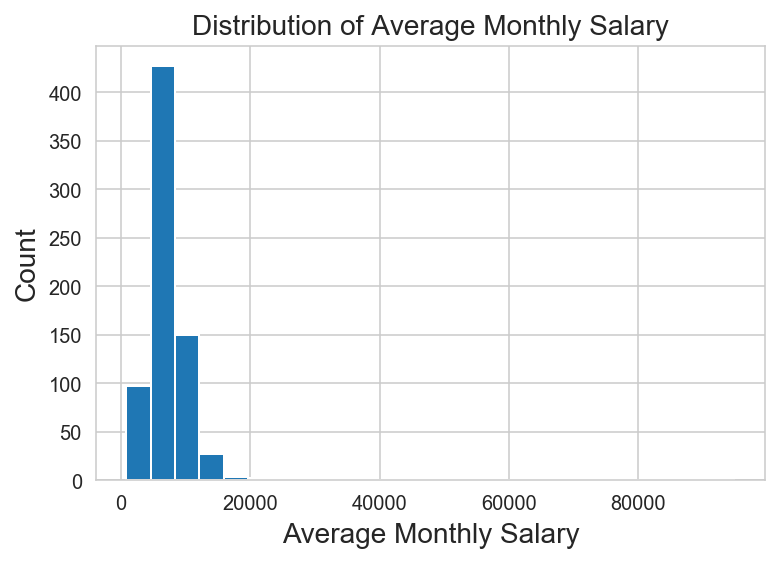

In [54]:
plt.hist(df_train['monthly_salary_avg'],bins=25)
plt.title('Distribution of Average Monthly Salary', fontsize=14); plt.xlabel('Average Monthly Salary', fontsize=14); plt.ylabel('Count', fontsize=14);
# Seems skewed significantly by outliers

(array([ 5., 11., 29., 15., 12., 37., 36., 38., 17., 63., 64., 50., 46.,
        51., 12., 33., 18., 34.,  7., 25., 21.,  4., 13.,  6., 11.]),
 array([ 2750.,  3100.,  3450.,  3800.,  4150.,  4500.,  4850.,  5200.,
         5550.,  5900.,  6250.,  6600.,  6950.,  7300.,  7650.,  8000.,
         8350.,  8700.,  9050.,  9400.,  9750., 10100., 10450., 10800.,
        11150., 11500.]),
 <a list of 25 Patch objects>)

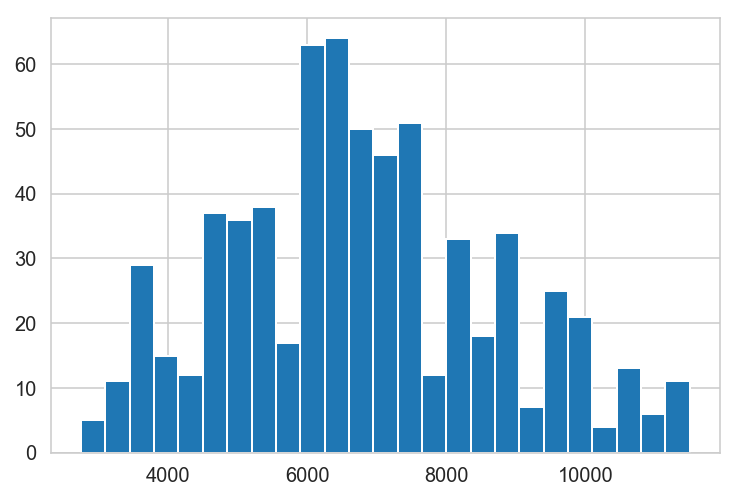

In [55]:
plt.hist(df_train['monthly_salary_avg'][[i for i in df_train.index if i not in df_train_outliers.index]], bins=25)

<a id='salary_trends_engineer_salary_class'/>
#### Engineer the High/Low Salary Class feature, based on median average monthly salary of Training Set

In [56]:
# median salary of training set - add salary label to classify high or low
df_train['monthly_salary_avg'].median()

6750.0

In [57]:
df['monthly_salary_class'] = df['monthly_salary_avg'].map(lambda x: 1 if x >= df_train['monthly_salary_avg'].median() else 0)
df_train = df.loc[df_train_indices]
df_test = df.loc[df_test_indices]

In [58]:
#### Check baseline for Xtrain
df_train['monthly_salary_class'].mean()

0.5232067510548524

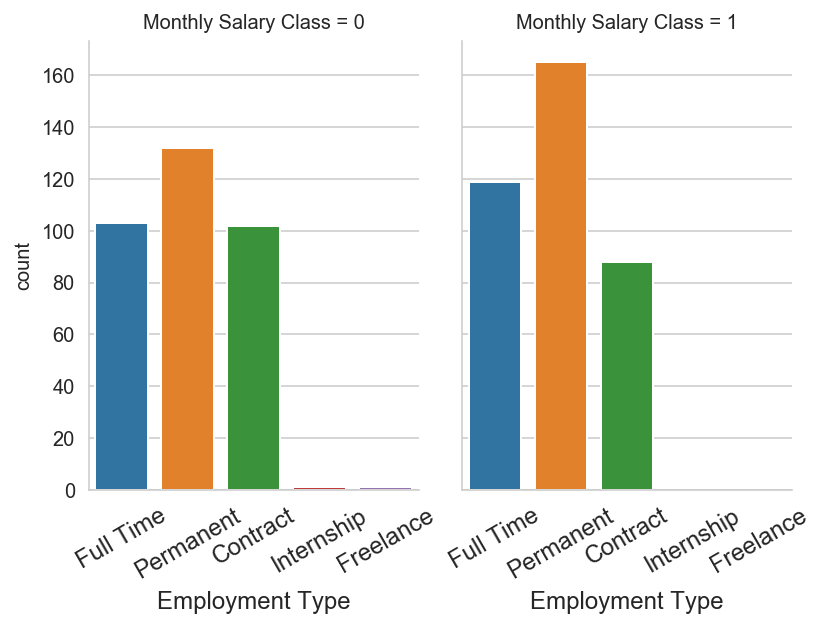

In [59]:
g=sns.catplot(x="job_employment_type", col="monthly_salary_class", data=df_train, kind="count", height=4, aspect=.7);

g.set_xticklabels(rotation=30, fontsize=12)
g.set_xlabels(label='Employment Type', fontsize=12)
_ = g.set_titles("Monthly Salary Class = {col_name}", fontsize=12)

There are more jobs that are Permanent / Full Time in Higher Salary Class compared to the Lower Salary Class.  
There are more jobs that are Contract in Lower Salary Class compared to the Higher Salary Class.  

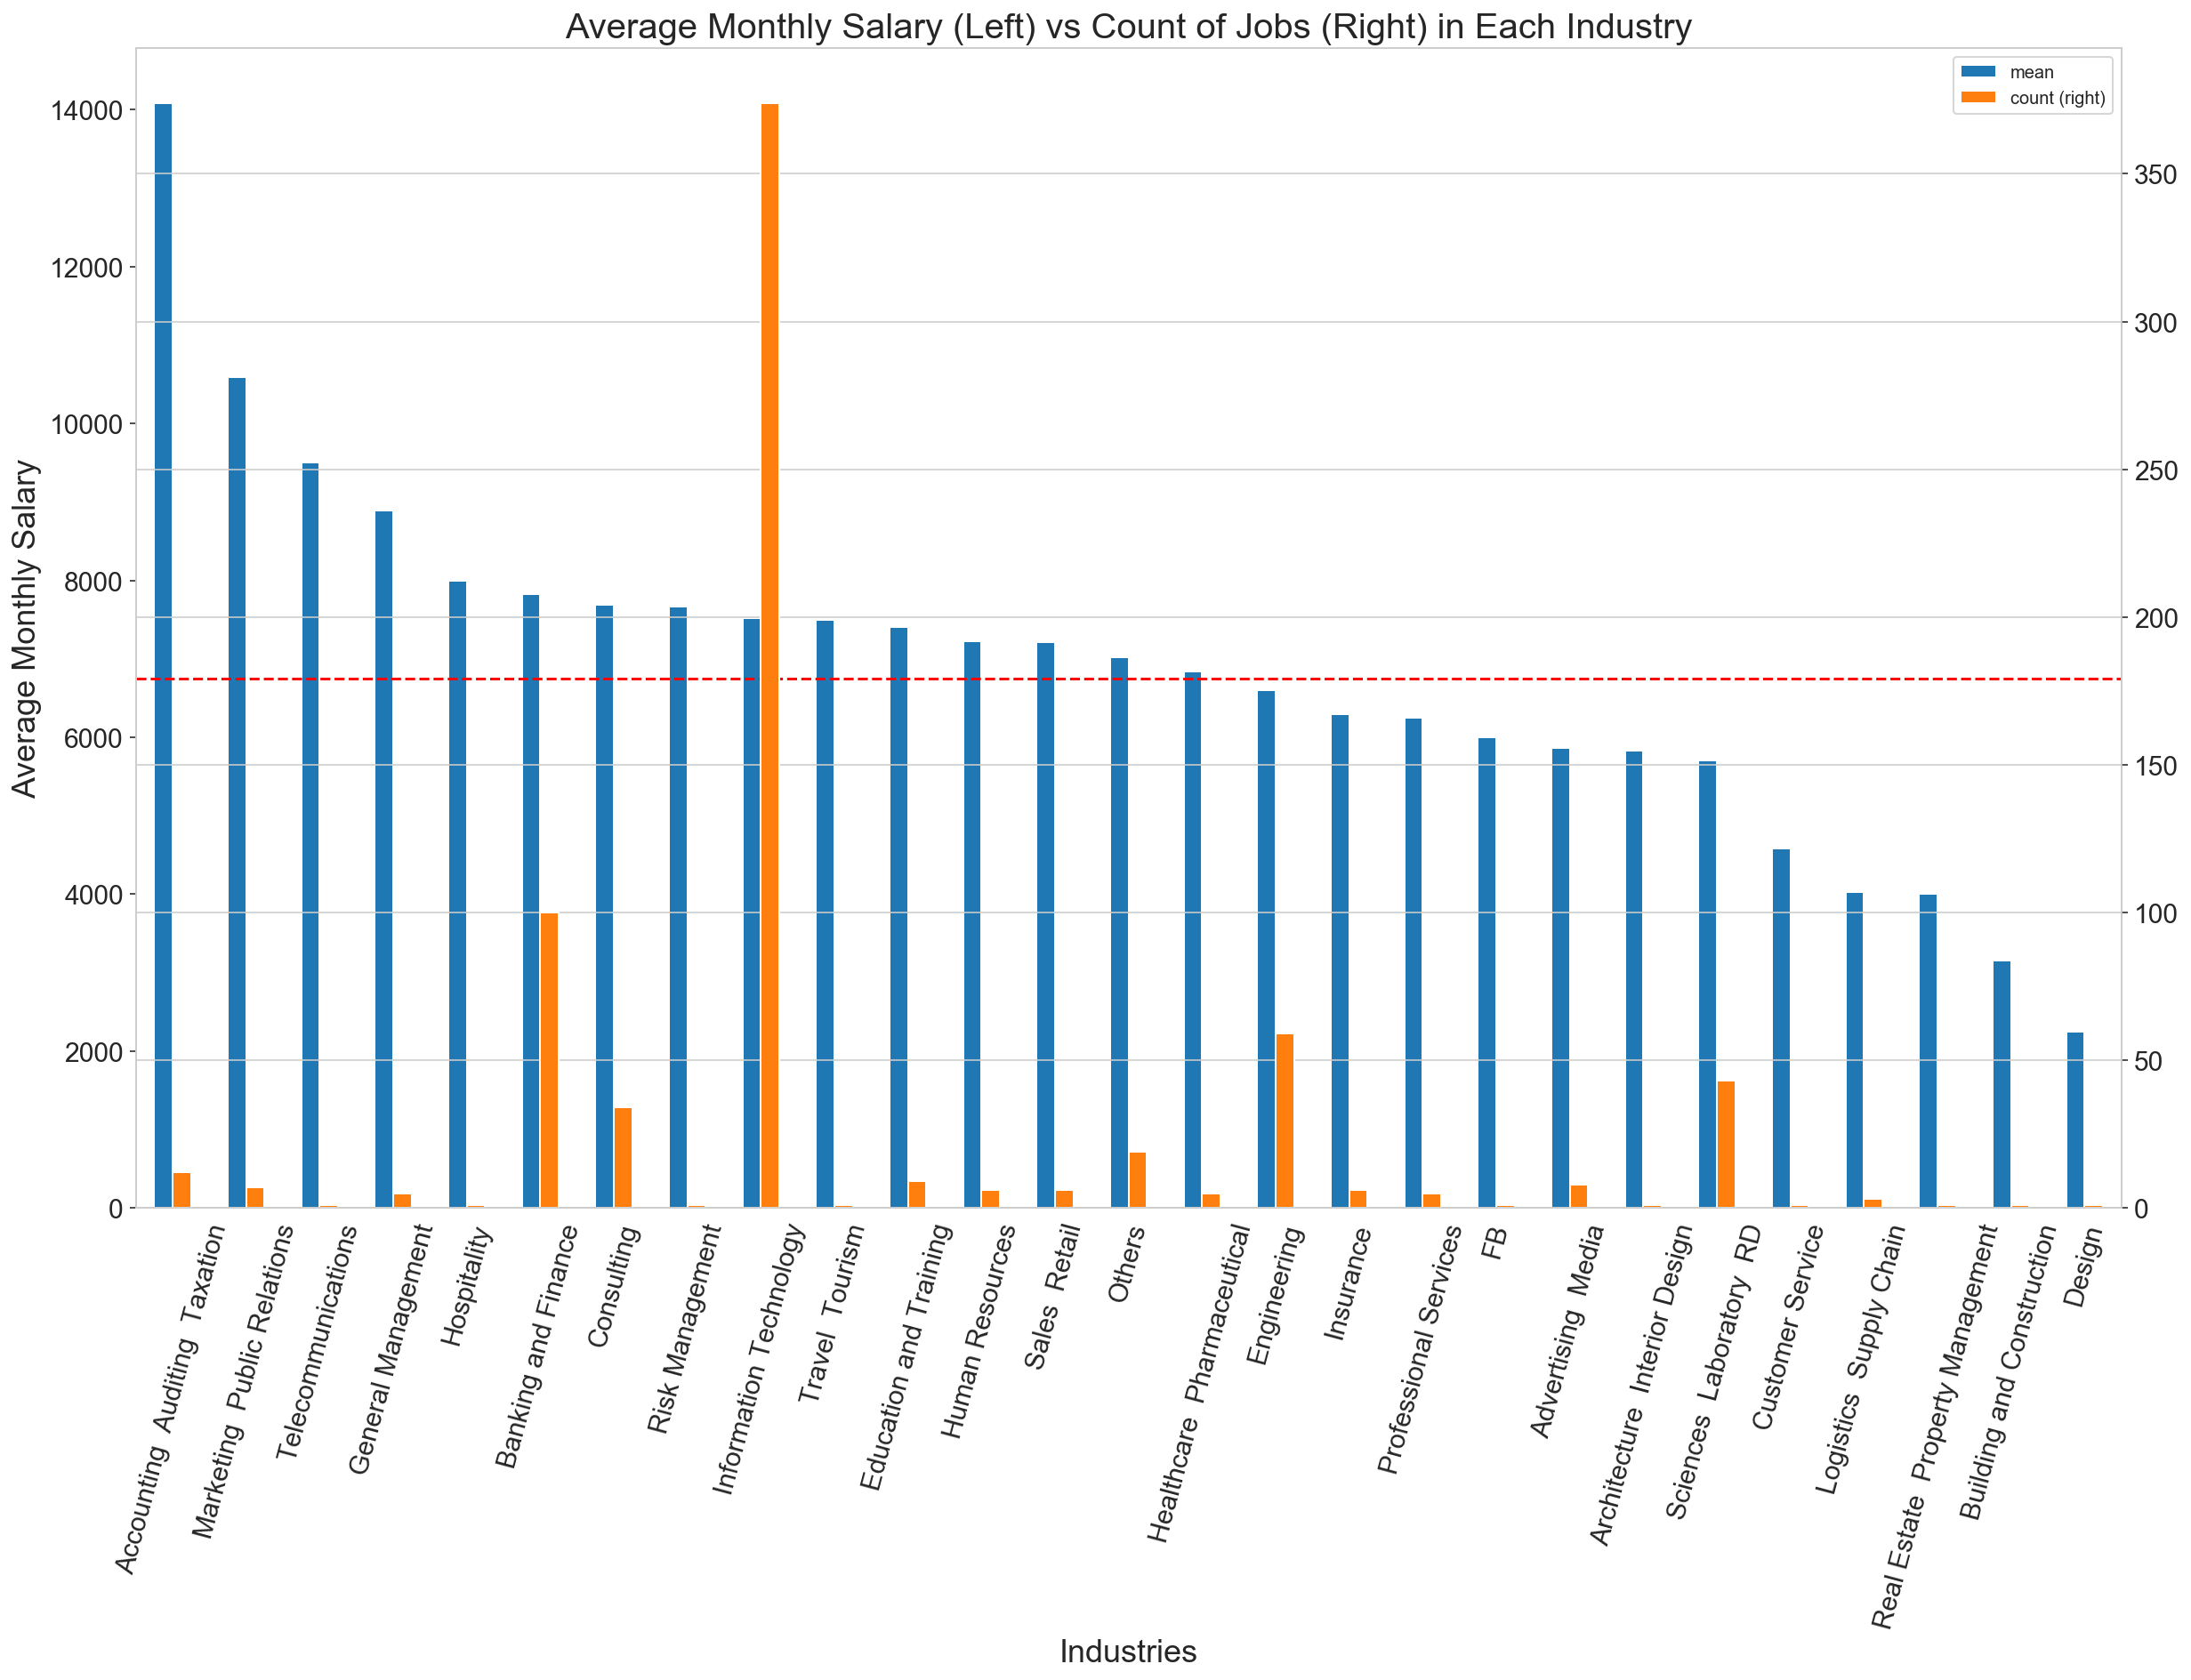

In [60]:
fig, ax = plt.subplots(figsize=(20,12))

#plt.tight_layout()
groupby_job_industry = df_train[['job_industry','monthly_salary_avg','monthly_salary_class']].groupby(['job_industry']).agg([np.mean, 'count'])
salary_groupby_job_industry = groupby_job_industry['monthly_salary_avg'].sort_values(by='mean',ascending=False)
width = 0.4
ax = salary_groupby_job_industry.plot(kind='bar', secondary_y = 'count', ax = ax, fontsize=15, rot= 75)
ax.set_title('Average Monthly Salary (Left) vs Count of Jobs (Right) in Each Industry', fontsize=20)
ax.set_xlabel('Industries', fontsize=18)
ax.set_ylabel('Average Monthly Salary', fontsize=18)

# draw the line for the cut-off for salary class
ax.axhline(y=df_train['monthly_salary_avg'].median(), color="red", linestyle="--",label='Cut-off for High or Low Salary Class')
                    

- The highest average data-related salaries is shown to be in Accounting / Auditing / Taxation and Telecommunications. 
- But some of the data may not be representative because the number of jobs represented in most industries are very limited. 
- The most well represented industries are (1) IT, (2) Banking / Finance and (3) Engineering (highest count), hence the average salary figures for those sectors may be more reliable.

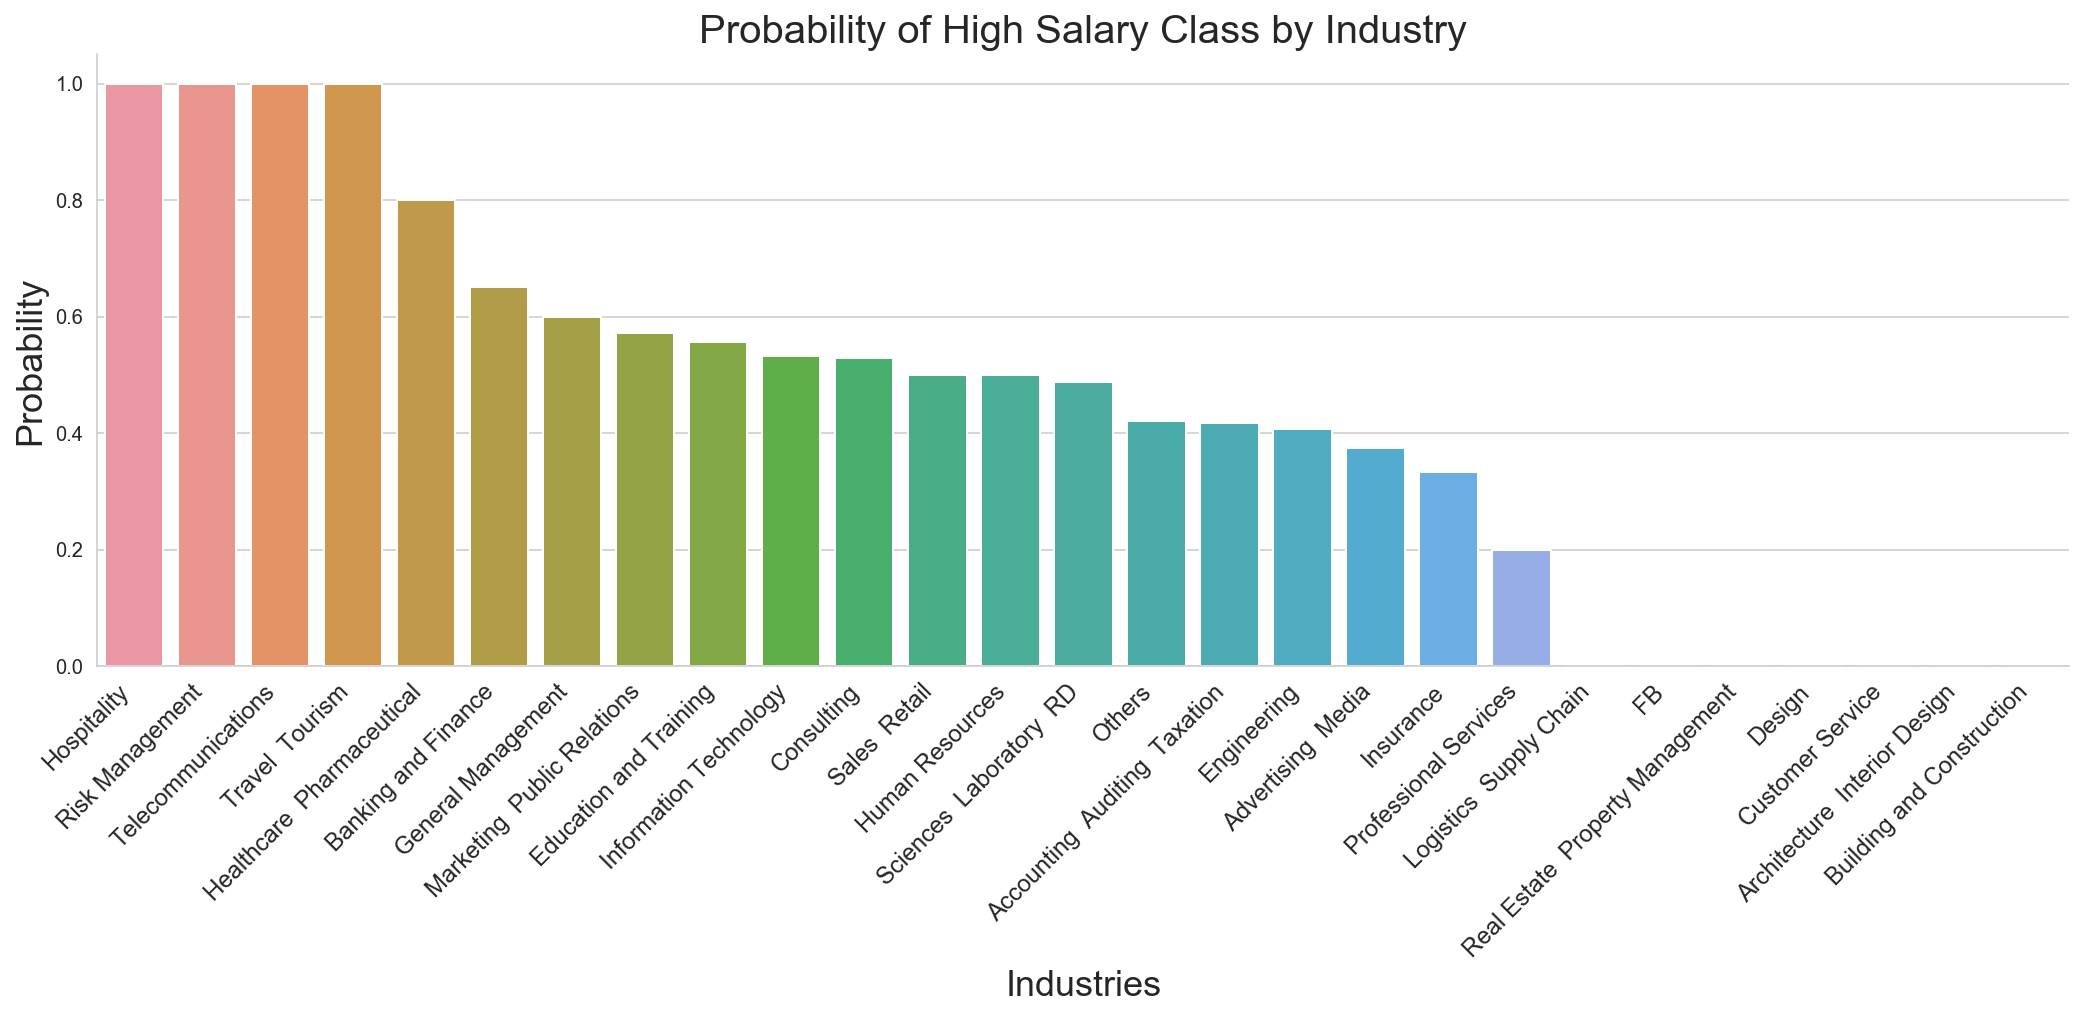

In [61]:
salary_class_groupby_job_industry = groupby_job_industry['monthly_salary_class'].reset_index().sort_values(by='mean',ascending=False)
g=sns.catplot( x='job_industry',y='mean', 
               data=salary_class_groupby_job_industry, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right', fontsize=12)
g.ax.set_title('Probability of High Salary Class by Industry', fontsize=20)
g.ax.set_xlabel('Industries', fontsize=18)
_=g.ax.set_ylabel('Probability', fontsize=18)

This is the probability of high salary by industry.
- Again, review the reliability of the indicated probability with the number of jobs represented per industry in the previous chart.
- Some of the data may not be representative because the number of jobs represented in most industries are very limited. 
- The most represented industries are (1) IT, (2) Banking / Finance and (3) Engineering (highest count), hence the probabilities for those sectors may be more reliable.

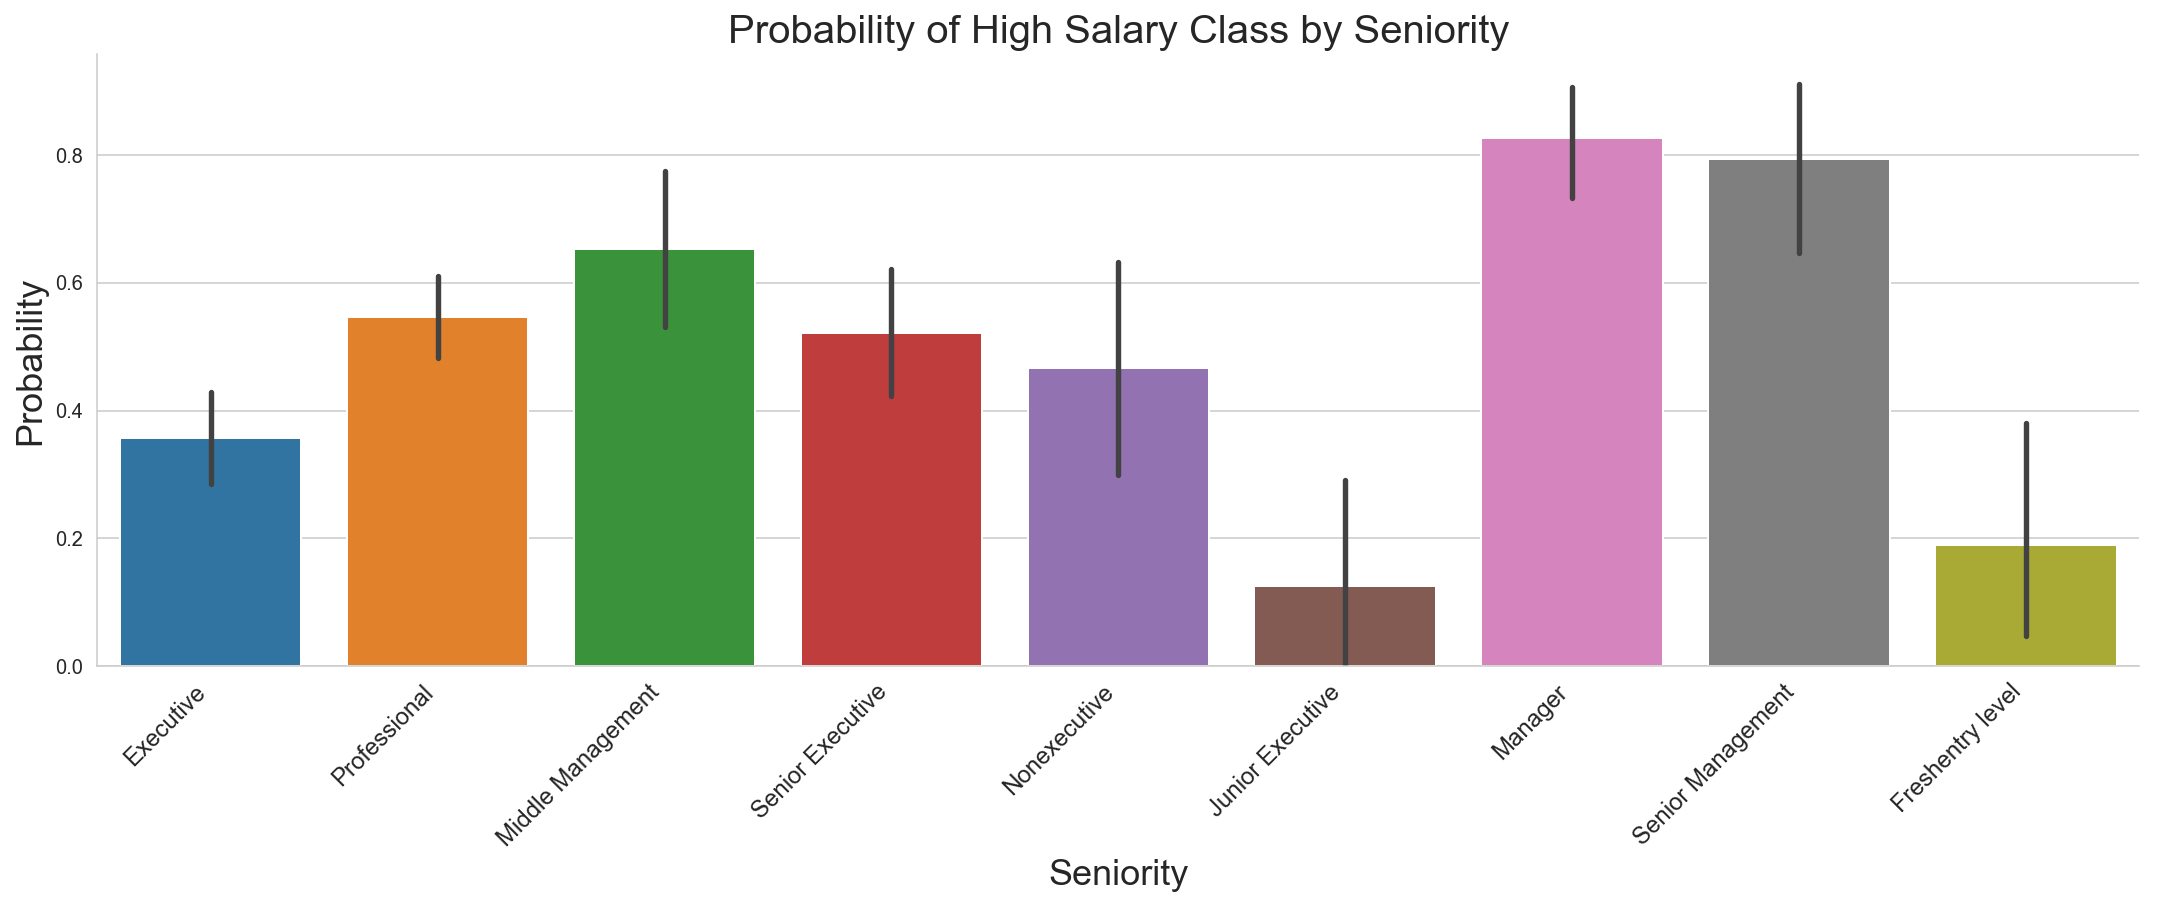

In [62]:
g=sns.catplot( x='job_seniority',y='monthly_salary_class', 
               data=df_train, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right', fontsize=12)
g.ax.set_title('Probability of High Salary Class by Seniority', fontsize=20)
g.ax.set_xlabel('Seniority', fontsize=18)
_=g.ax.set_ylabel('Probability', fontsize=18)

This is the probability of high salary job by seniority.
 - It seems either 'Manager' or 'Management' gives a higher chance of high salary, followed by 'Professional' and 'Senior'.
 - The interesting observation is that non-executives have a higher probability of getting higher salary than 'Executives'!  This may be due to a non-disriminatory usage of the term 'Executive'.
 - As expected 'Junior Executive' has high probability of getting lower salary, but unexpectedly that is even higher than Fresh / Entry level.

<a id='salary_trends_engineer_NLP'/>

#### Perform NLP preprocessing

In [63]:
# Use CountVectorizer for job_title for Bag of Words
jt_cv = CountVectorizer(ngram_range=(1, 2),max_features=1000,stop_words='english',min_df=2)
matrix_train_job_title_cv = jt_cv.fit_transform(df_train['job_title'])
matrix_test_job_title_cv = jt_cv.transform(df_test['job_title'])

df_train_job_title_cv = pd.DataFrame(matrix_train_job_title_cv.todense(), columns=['jt_' + n for n in jt_cv.get_feature_names()])
df_test_job_title_cv = pd.DataFrame(matrix_test_job_title_cv.todense(), columns=['jt_' + n for n in jt_cv.get_feature_names()])

In [64]:
# Use CountVectorizer for job_description for Bag of Words
jd_cv = CountVectorizer(ngram_range=(2, 3),max_features=10000,stop_words='english',min_df=2)
matrix_train_job_description_cv = jd_cv.fit_transform(df_train['job_description'])
matrix_test_job_description_cv = jd_cv.transform(df_test['job_description'])

df_train_job_description_cv = pd.DataFrame(matrix_train_job_description_cv.todense(), columns=['jd_' + n for n in jd_cv.get_feature_names()])
df_test_job_description_cv = pd.DataFrame(matrix_test_job_description_cv.todense(), columns=['jd_' + n for n in jd_cv.get_feature_names()])

In [65]:
# Use CountVectorizer for requirements for Bag of Words
jr_cv = CountVectorizer(ngram_range=(3, 3),max_features=10000,stop_words='english',min_df=2)
matrix_train_job_requirements_cv = jr_cv.fit_transform(df_train['job_requirements'])
matrix_test_job_requirements_cv = jr_cv.transform(df_test['job_requirements'])

df_train_job_requirements_cv = pd.DataFrame(matrix_train_job_requirements_cv.todense(), columns=['jr_' + n for n in jr_cv.get_feature_names()])
df_test_job_requirements_cv = pd.DataFrame(matrix_test_job_requirements_cv.todense(), columns=['jr_' + n for n in jr_cv.get_feature_names()])

In [66]:
# Function to get total word count from sparse matrix
def get_freq_words(sparse_counts, columns):
    # sparse_counts is a sparse matrix, so sum() returns a 'matrix' datatype ...
    # which we then convert into a 1-D ndarray for sorting
    word_counts = np.asarray(sparse_counts.sum(axis=0)).reshape(-1)

    # argsort() returns smallest first, so we reverse the result
    largest_count_indices = word_counts.argsort()[::-1]

    # pretty-print the results! Remember to always ask whether they make sense ...
    freq_words = pd.Series(word_counts[largest_count_indices], 
                           index=columns[largest_count_indices])

    return freq_words

In [67]:
freq_words_jt = get_freq_words(matrix_train_job_title_cv, np.array(jt_cv.get_feature_names()))
freq_words_jt[:20]

analyst             243
data                229
business            201
engineer            151
business analyst    147
senior              125
manager              81
scientist            73
data engineer        50
data scientist       49
developer            46
research             43
data analyst         39
consultant           36
analytics            35
big                  32
lead                 32
big data             30
technology           26
associate            25
dtype: int64

In [68]:
freq_words_jd = get_freq_words(matrix_train_job_description_cv, np.array(jd_cv.get_feature_names()))
freq_words_jd[:20]

machine learning         299
big data                 210
data analytics           129
business requirements    124
business intelligence    108
business analyst          96
deep learning             90
data science              90
best practices            80
work closely              79
end end                   72
business needs            63
team members              59
design develop            56
real time                 54
data analysis             52
data mining               50
data driven               49
data sources              49
large scale               48
dtype: int64

In [69]:
freq_words_jr = get_freq_words(matrix_train_job_requirements_cv, np.array(jr_cv.get_feature_names()))
freq_words_jr[:20]

degree computer science            101
problem solving skills              75
shortlisted candidates notified     66
analytical problem solving          55
regret shortlisted candidates       46
minimum years experience            44
computer science engineering        44
written communication skills        42
bachelor degree computer            38
computer science related            38
verbal written communication        37
years working experience            34
experience big data                 32
communication skills ability        31
ability work independently          31
computer science information        30
selection criteria based            30
recruitment policies policies       30
amended time time                   30
policies policies amended           30
dtype: int64

#### Preparing the other features: job_industry and job_seniority

In [70]:
df_job_industry = pd.get_dummies(df['job_industry'], prefix='ji', prefix_sep='_', dummy_na=False, sparse=False, drop_first=True, dtype=None).reset_index(drop=True)
df_train_job_industry = df_job_industry.loc[df_train_indices].reset_index(drop=True)
df_test_job_industry = df_job_industry.loc[df_test_indices].reset_index(drop=True)
df_test_job_industry.head(5)

,ji_Advertising Media,ji_Architecture Interior Design,ji_Banking and Finance,ji_Building and Construction,ji_Consulting,ji_Customer Service,ji_Design,ji_Education and Training,ji_Engineering,ji_FB,...,ji_Logistics Supply Chain,ji_Marketing Public Relations,ji_Others,ji_Professional Services,ji_Real Estate Property Management,ji_Risk Management,ji_Sales Retail,ji_Sciences Laboratory RD,ji_Telecommunications,ji_Travel Tourism
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [71]:
x = df['job_seniority'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
df_job_seniority = pd.get_dummies(x, prefix='js', columns=['job_seniority']).groupby(level=0).sum()
df_train_job_seniority = df_job_seniority.loc[df_train_indices].reset_index(drop=True)
df_test_job_seniority = df_job_seniority.loc[df_test_indices].reset_index(drop=True)
df_test_job_seniority.head(5)

,js_Executive,js_Freshentry level,js_Junior Executive,js_Manager,js_Middle Management,js_Nonexecutive,js_Professional,js_Senior Executive,js_Senior Management
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0


In [72]:
y_train = df.loc[df_train_indices,'monthly_salary_class']
y_test = df.loc[df_test_indices,'monthly_salary_class']

<a id='salary_trends_train_test'/>
### Salary Trends:  Train and Test

<a id='salary_trends_prep_models'/>
#### Prepare models: Random Forest, SGD Classifer with L1 Penalty, SGD Classifier with Elastic Net Penalty

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# RandmomForestClassifier for ensemble learning and feature importance
# All params are taken from library defaults.
rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_features='auto', 
    min_impurity_decrease=0.0, 
    min_samples_leaf=1, min_samples_split=2,
    min_weight_fraction_leaf=0.0, n_estimators=100, oob_score=False, random_state=38, verbose=0,
    warm_start=False)

# SGDClassifier with L1 to achieve gradient descent and feature selection
# parameters: 
#   penalty = 'L1' - for feature selection properties
#   random_state = 38
# Other parameters are taken from package's defaults.
sgd_clf_l1 = SGDClassifier(loss='hinge', penalty='l1', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, \
                max_iter=1000, tol=1e-3, shuffle=True, verbose=0, epsilon=0.1, random_state=38, learning_rate='optimal', \
                eta0=0.0, power_t=0.5,  warm_start=False, average=False)

# SGDClassifier with elasticnet to achieve gradient descent
# parameters: 
#   penalty = 'elasticnet' - elasticnet
#   random_state = 38
# The other parameters is taken from package default
sgd_clf_elastic_net = SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, \
                max_iter=1000, tol=1e-3, shuffle=True, verbose=0, epsilon=0.1, random_state=38, learning_rate='optimal', \
                eta0=0.0, power_t=0.5,  warm_start=False, average=False)

In [74]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
# no need to scale because using SGD and Random Forest classifiers.

<a id='salary_trends_train_test_ji_js'/>
#### Train and Test with features: 
- Job Industry (prefix 'ji_')
- Job Seniority (prefix: 'js_')

In [75]:
# #############################################################################
# Benchmark classifiers for job titles 'data scientist', 'data analyst' and others
# #############################################################################

from time import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

def benchmark(clf,X_train,y_train,X_test,y_test, target_names, feature_description, print_report=True, print_cm=True):
    
    is_multi_class =  True if (len(target_names) > 2) else False
    
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    score = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
    print("cross validation Score: {:0.3} ± {:0.3}".format(score.mean().round(3), score.std().round(3)))   
    
    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    accuracy_score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % accuracy_score)

    roc_auc_score = None
    if (not is_multi_class):
        roc_auc_score = metrics.roc_auc_score(y_test, pred)
        print("auc_roc score:   %0.3f" % roc_auc_score)    

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("top 10 keywords per class:")
        # check multinomial or binary classification
        t = target_names if is_multi_class else [target_names[1]]
        for i, label in enumerate(t):        
            top_x_features = pd.DataFrame({'coef':clf.coef_[i],
                                'mag':np.abs(clf.coef_[i]),
                                'feature':X_train.columns}).sort_values('mag', ascending=True, inplace=False).tail(20)
            top_x_features.plot(kind='barh', figsize=(8,8))
            plt.yticks(range((len(top_x_features))), top_x_features['feature'])
            plt.title('Top Features for ' + label, fontsize=12)
        plt.show()
        
        
    if hasattr(clf, 'feature_importances_'):        
        feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns).reset_index()
        feature_importances.columns = ['feature', 'importance']
        feature_importances.sort_values('importance', ascending=True, inplace=True)
        top_x_features = feature_importances.tail(20)
        top_x_features.plot(kind='barh', figsize=(8,8))
        plt.yticks(range((len(top_x_features))), top_x_features['feature'])
        plt.title('Top Features', fontsize=12)
        plt.show()
      
    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))   

    return {
        'Model': clf,
        'Features Used': feature_description,
        'Accuracy Score': accuracy_score,
        'ROC AUC Score': roc_auc_score
        }


In [76]:
#### create a new dataframe for storing results     
results = pd.DataFrame()

#### map the target values to names: 0 - Low Salary, 1 - High Salary
target_names_salary_class = ['Low Salary','High Salary']

In [77]:
X_train_ji_js = pd.concat([df_train_job_industry,df_train_job_seniority],axis=1,sort=False)
X_test_ji_js = pd.concat([df_test_job_industry,df_test_job_seniority],axis=1,sort=False)

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=38, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)
train time: 0.004s
cross validation Score: 0.578 ± 0.024
test time:  0.004s
accuracy:   0.513
auc_roc score:   0.517
dimensionality: 35
top 10 keywords per class:


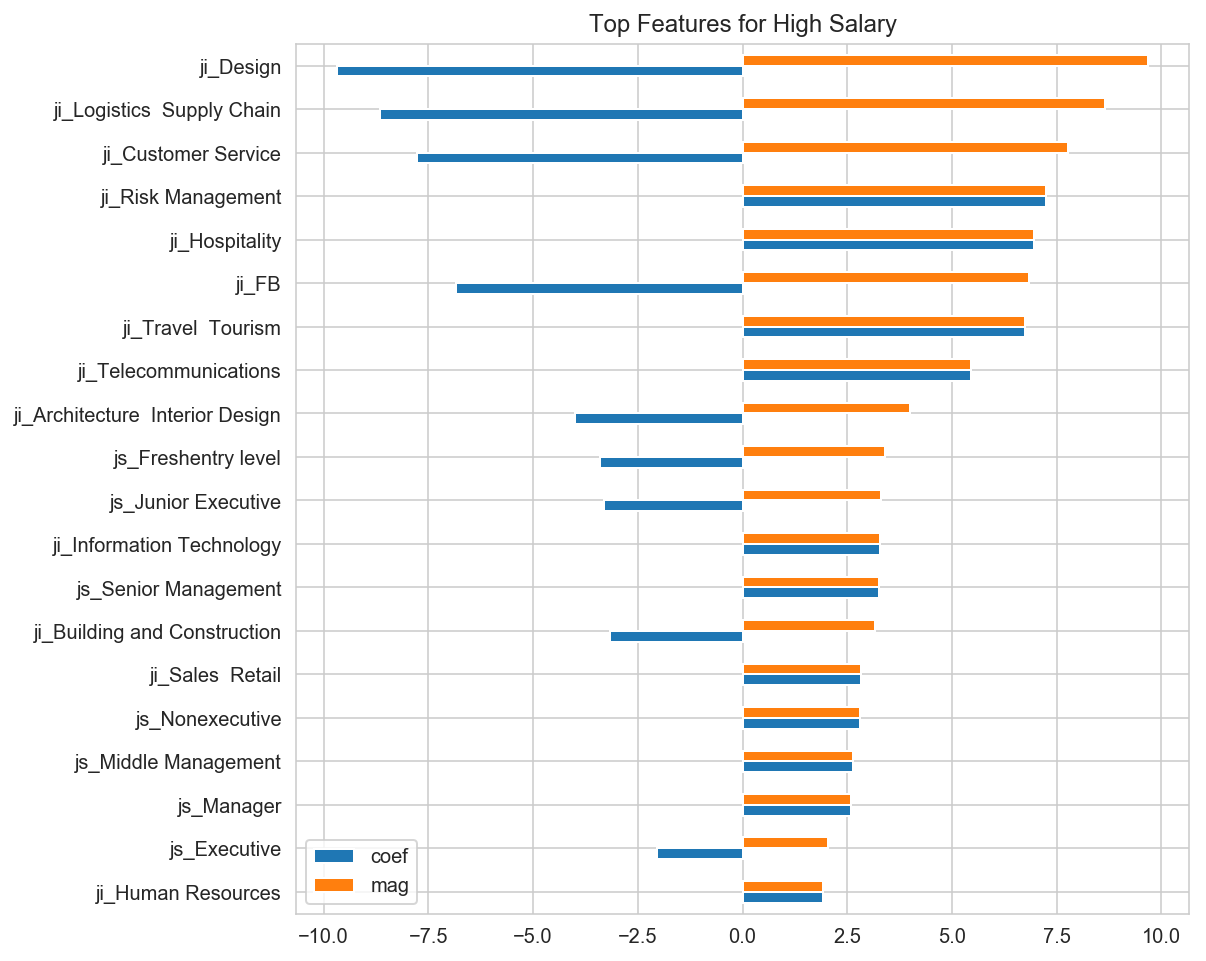

classification report:
             precision    recall  f1-score   support

 Low Salary       0.55      0.25      0.34       121
High Salary       0.50      0.79      0.61       117

avg / total       0.52      0.51      0.47       238

confusion matrix:
[[30 91]
 [25 92]]


In [78]:
results = results.append(benchmark(sgd_clf_l1, X_train_ji_js, y_train, X_test_ji_js, y_test, target_names_salary_class ,feature_description='Job Industry and Seniority'), ignore_index=True)

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=38, verbose=0, warm_start=False)
train time: 0.253s
cross validation Score: 0.636 ± 0.014
test time:  0.000s
accuracy:   0.634
auc_roc score:   0.636


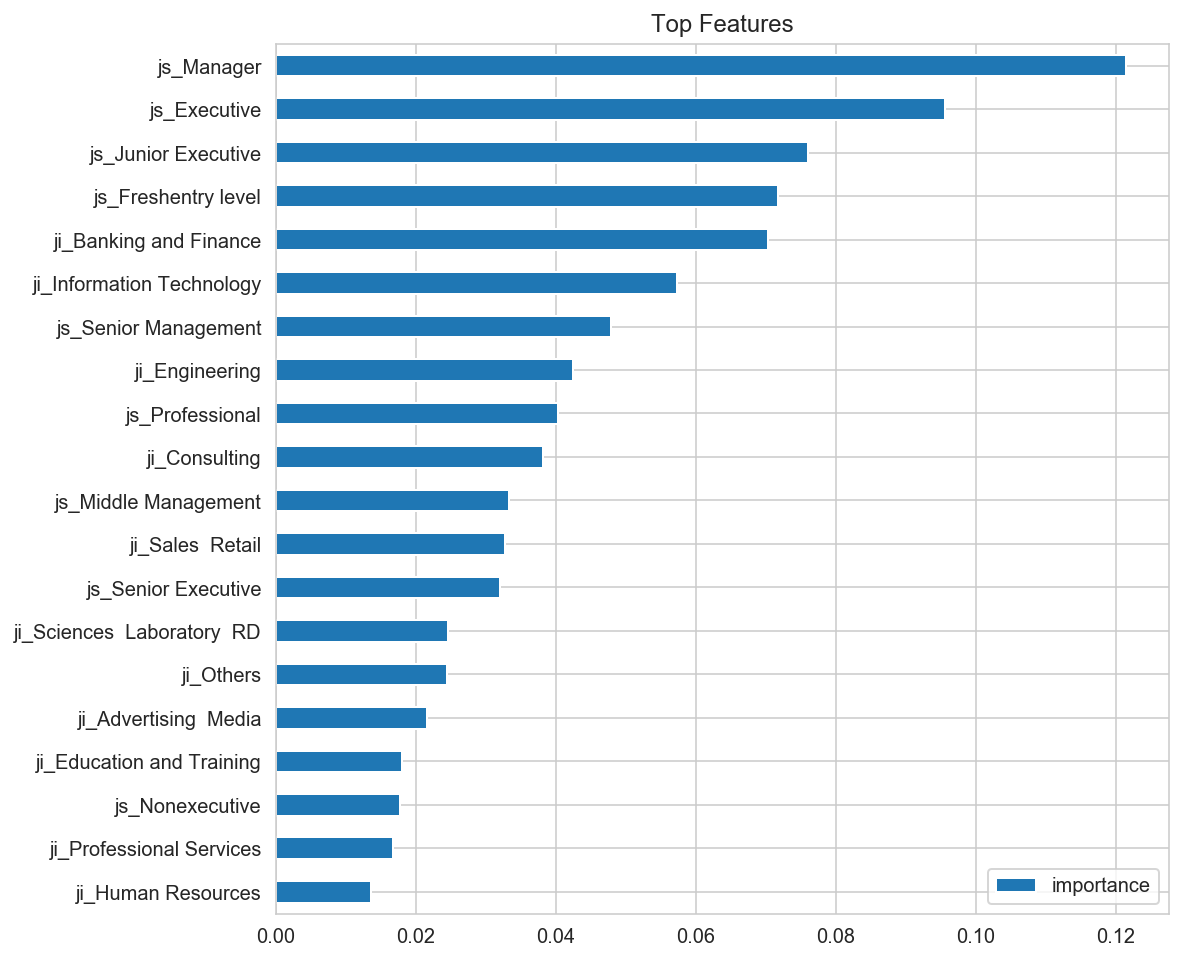

classification report:
             precision    recall  f1-score   support

 Low Salary       0.67      0.56      0.61       121
High Salary       0.61      0.71      0.66       117

avg / total       0.64      0.63      0.63       238

confusion matrix:
[[68 53]
 [34 83]]


In [79]:
results = results.append(benchmark(rf_clf, X_train_ji_js, y_train, X_test_ji_js, y_test, target_names_salary_class ,feature_description='Job Industry and Seniority'), ignore_index=True)

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=38, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)
train time: 0.010s
cross validation Score: 0.578 ± 0.024
test time:  0.000s
accuracy:   0.513
auc_roc score:   0.517
dimensionality: 35
top 10 keywords per class:


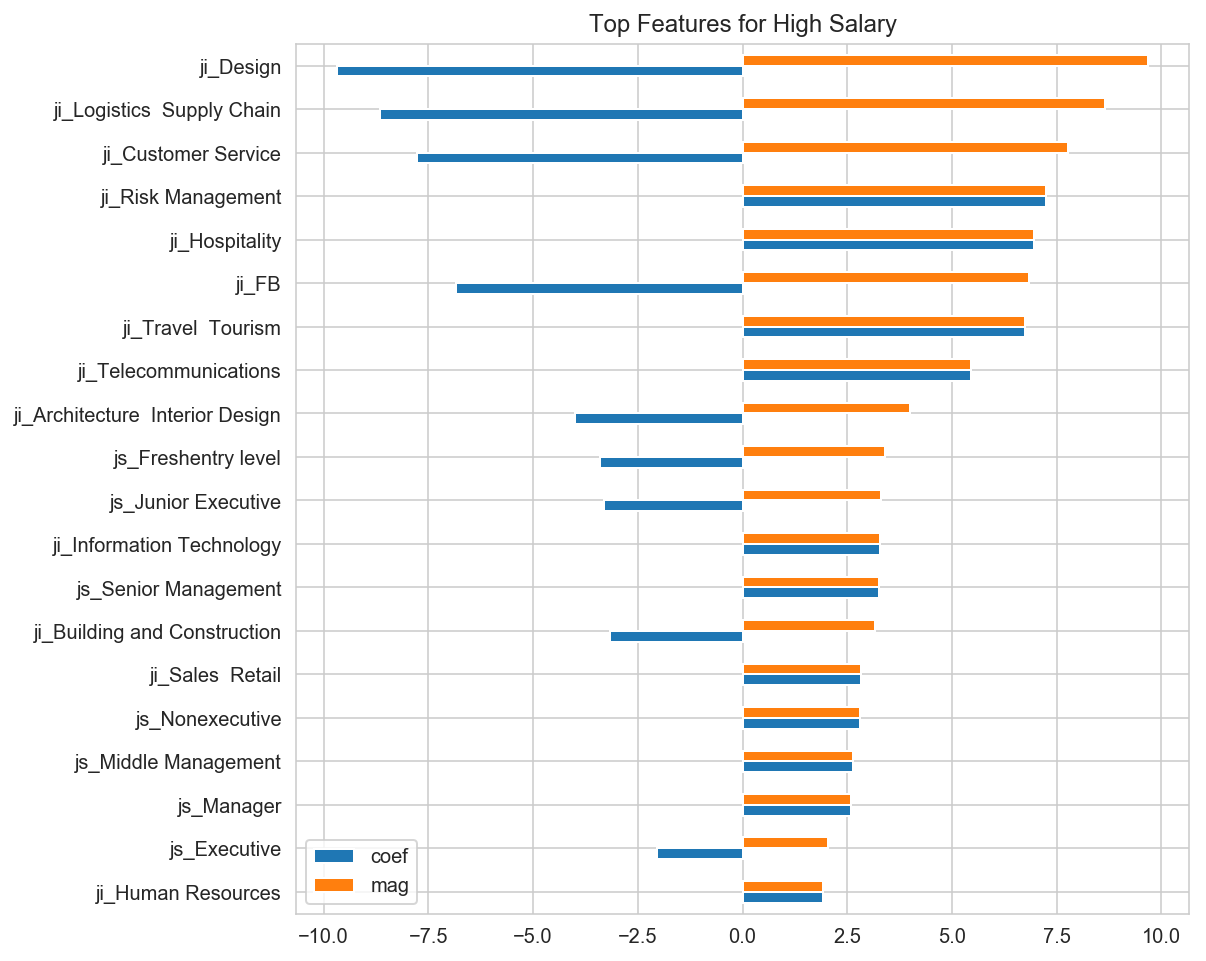

classification report:
             precision    recall  f1-score   support

 Low Salary       0.55      0.25      0.34       121
High Salary       0.50      0.79      0.61       117

avg / total       0.52      0.51      0.47       238

confusion matrix:
[[30 91]
 [25 92]]


In [80]:
results = results.append(benchmark(sgd_clf_l1, X_train_ji_js, y_train, X_test_ji_js, y_test, target_names_salary_class ,feature_description='Job Industry and Seniority'), ignore_index=True)

In [81]:
results

,Accuracy Score,Features Used,Model,ROC AUC Score
0,0.512605,Job Industry and Seniority,"SGDClassifier(alpha=0.0001, average=False, cla...",0.517129
1,0.634454,Job Industry and Seniority,"(DecisionTreeClassifier(class_weight=None, cri...",0.635693
2,0.512605,Job Industry and Seniority,"SGDClassifier(alpha=0.0001, average=False, cla...",0.517129


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=38,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
train time: 0.007s
cross validation Score: 0.606 ± 0.05
test time:  0.000s
accuracy:   0.584
auc_roc score:   0.588
dimensionality: 35
top 10 keywords per class:


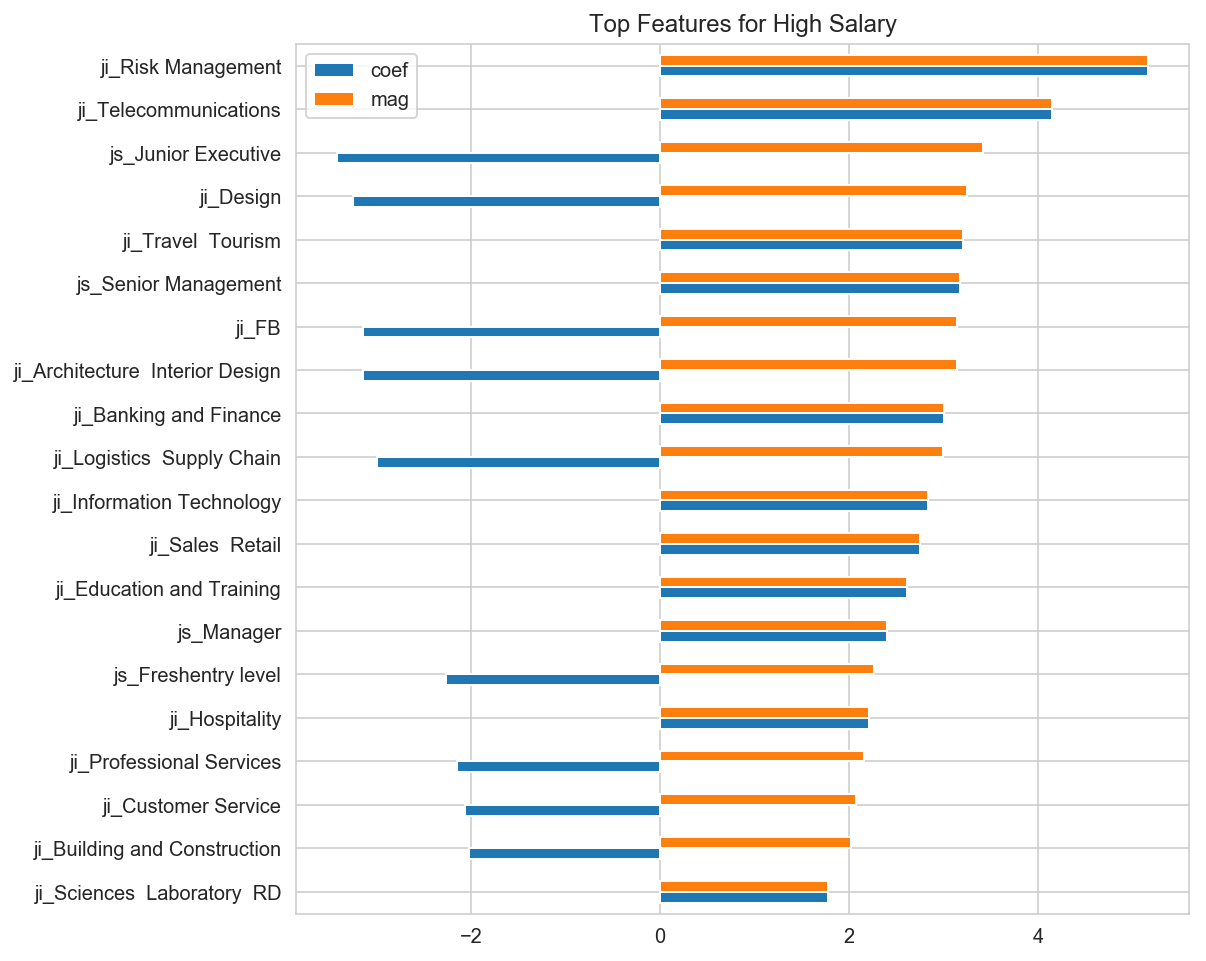

classification report:
             precision    recall  f1-score   support

 Low Salary       0.67      0.36      0.46       121
High Salary       0.55      0.82      0.66       117

avg / total       0.61      0.58      0.56       238

confusion matrix:
[[43 78]
 [21 96]]


In [82]:
results = results.append(benchmark(sgd_clf_elastic_net, X_train_ji_js, y_train, X_test_ji_js, y_test, target_names_salary_class ,feature_description='Job Industry and Seniority'), ignore_index=True)

<a id='salary_trends_train_test_jt'/>
#### Train and Test with features: 
- Job Title (prefix 'jt_')

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=38, verbose=0, warm_start=False)
train time: 0.416s
cross validation Score: 0.654 ± 0.041
test time:  0.022s
accuracy:   0.643
auc_roc score:   0.642


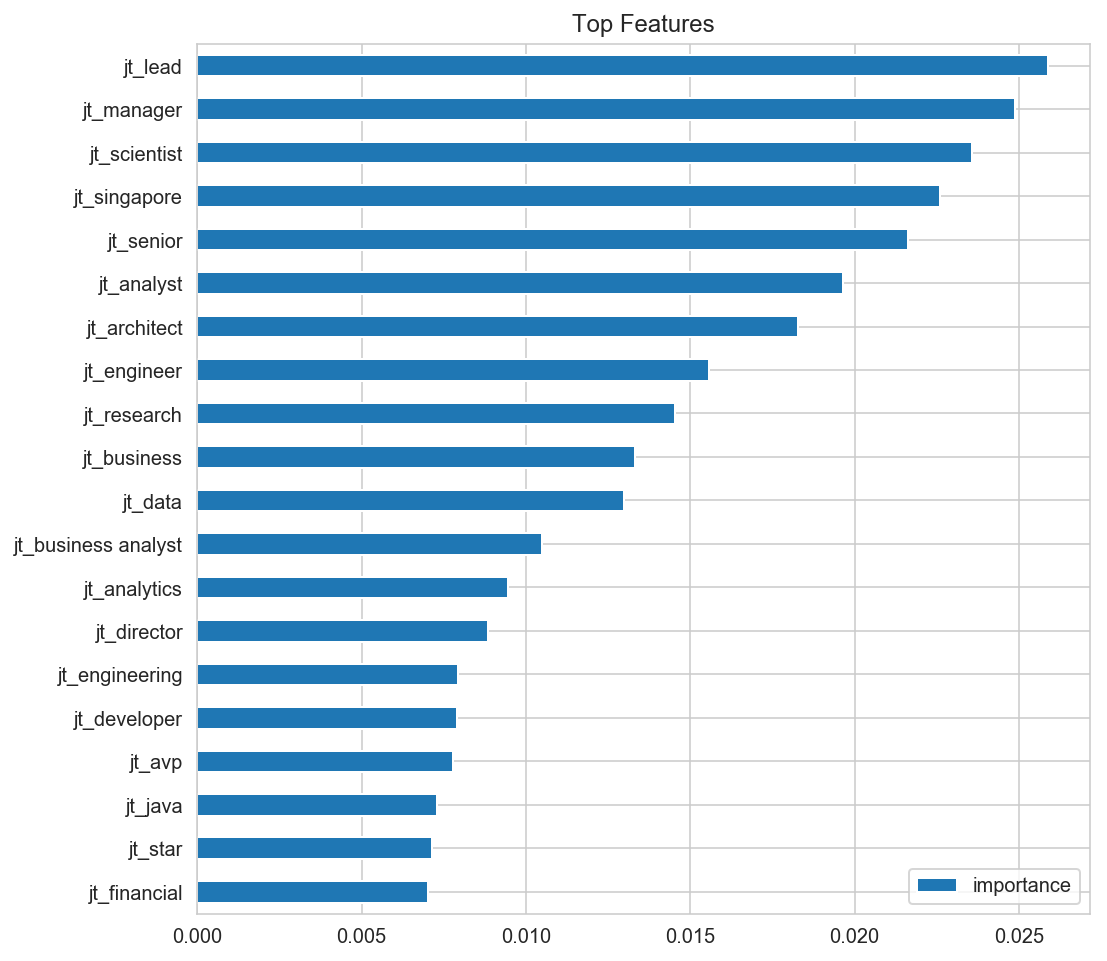

classification report:
             precision    recall  f1-score   support

 Low Salary       0.64      0.68      0.66       121
High Salary       0.65      0.61      0.63       117

avg / total       0.64      0.64      0.64       238

confusion matrix:
[[82 39]
 [46 71]]


In [83]:
results = results.append(benchmark(rf_clf, df_train_job_title_cv, y_train, df_test_job_title_cv, y_test, target_names_salary_class ,feature_description='Job Title'), ignore_index=True)

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=38, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)
train time: 0.053s
cross validation Score: 0.664 ± 0.037
test time:  0.000s
accuracy:   0.626
auc_roc score:   0.623
dimensionality: 499
top 10 keywords per class:


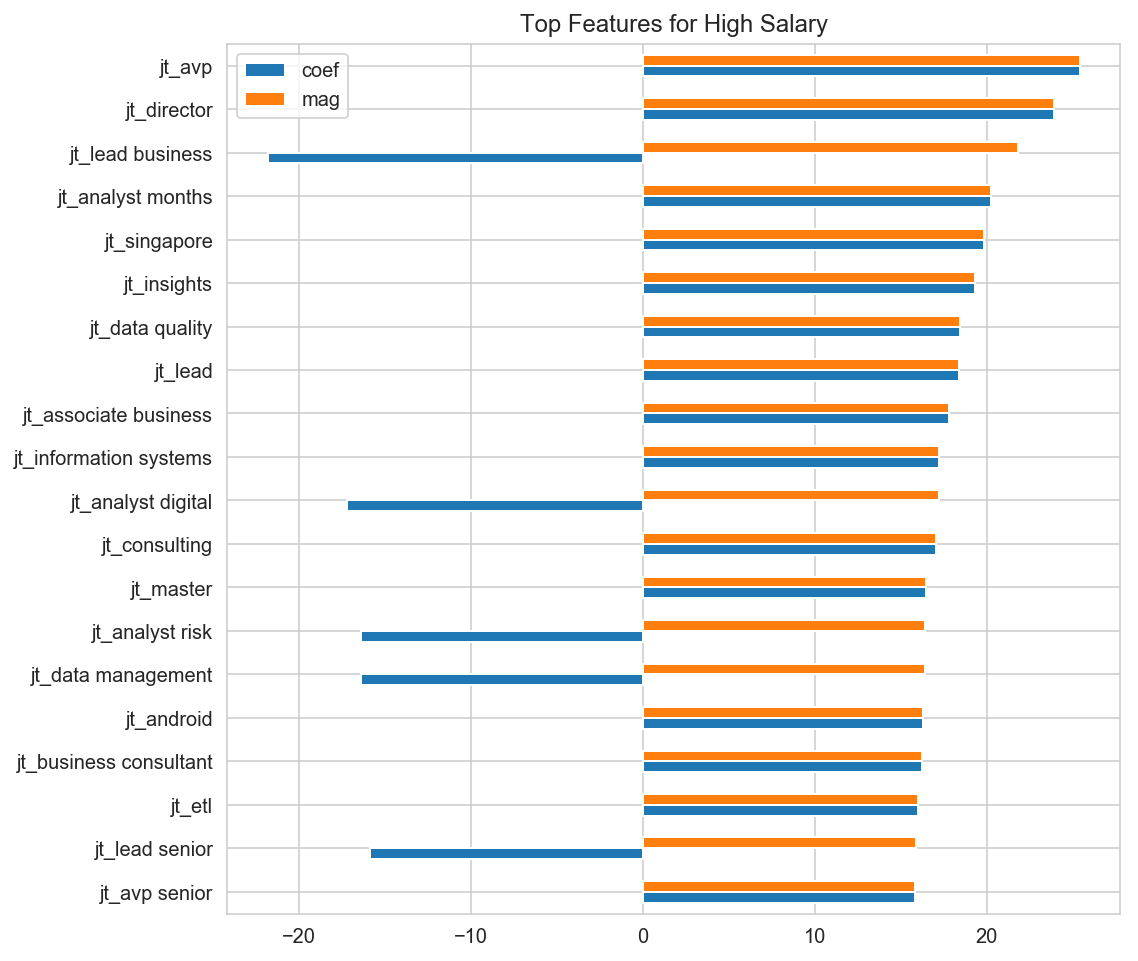

classification report:
             precision    recall  f1-score   support

 Low Salary       0.60      0.79      0.68       121
High Salary       0.68      0.45      0.54       117

avg / total       0.64      0.63      0.61       238

confusion matrix:
[[96 25]
 [64 53]]


In [84]:
results = results.append(benchmark(sgd_clf_l1, df_train_job_title_cv, y_train, df_test_job_title_cv, y_test, target_names_salary_class ,feature_description='Job Title'), ignore_index=True)

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=38,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
train time: 0.024s
cross validation Score: 0.627 ± 0.012
test time:  0.001s
accuracy:   0.643
auc_roc score:   0.643
dimensionality: 499
top 10 keywords per class:


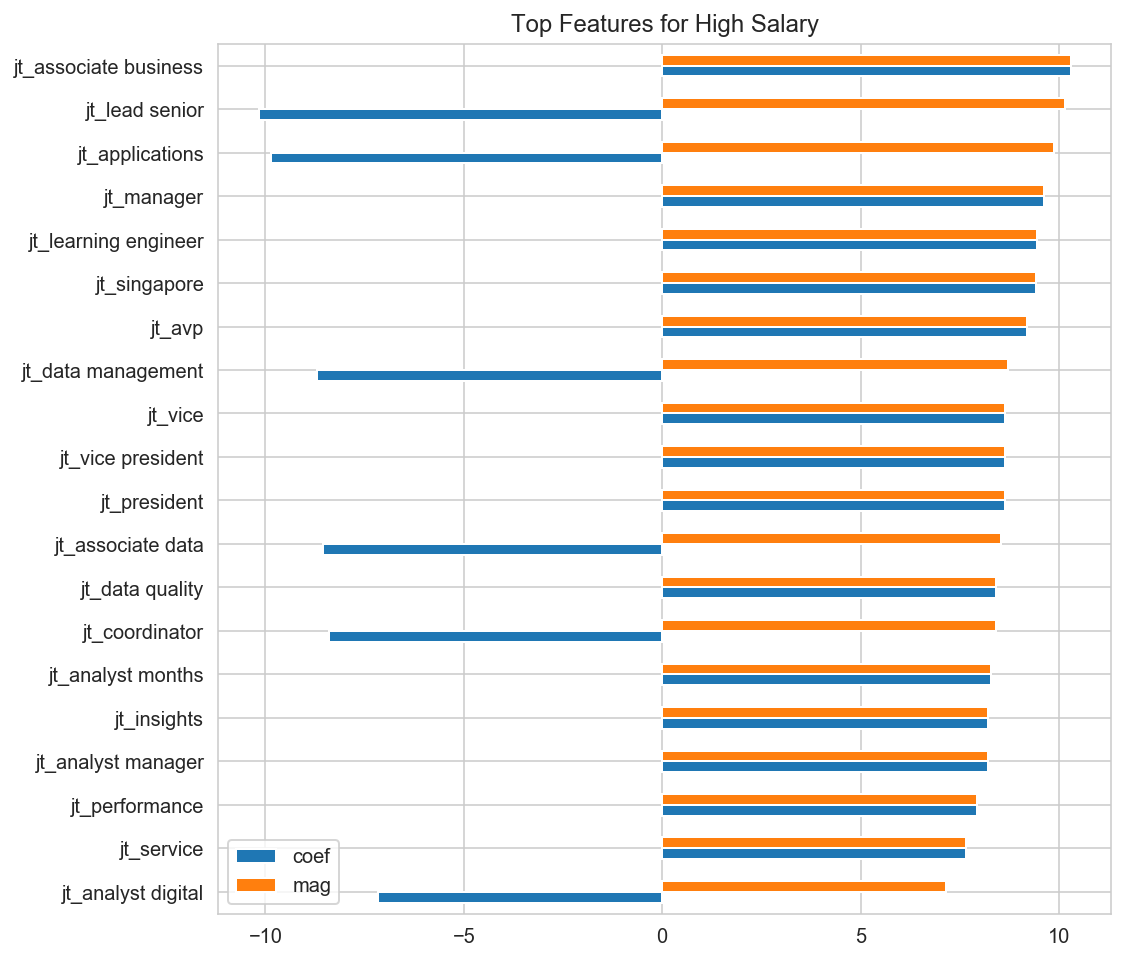

classification report:
             precision    recall  f1-score   support

 Low Salary       0.65      0.64      0.65       121
High Salary       0.64      0.64      0.64       117

avg / total       0.64      0.64      0.64       238

confusion matrix:
[[78 43]
 [42 75]]


In [85]:
results = results.append(benchmark(sgd_clf_elastic_net, df_train_job_title_cv, y_train, df_test_job_title_cv, y_test, target_names_salary_class ,feature_description='Job Title'), ignore_index=True)

<a id='salary_trends_train_test_jd'/>
#### Train and Test with features: 
- Job Description (prefix 'jd_')

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=38, verbose=0, warm_start=False)
train time: 3.989s
cross validation Score: 0.601 ± 0.042
test time:  0.063s
accuracy:   0.613
auc_roc score:   0.611


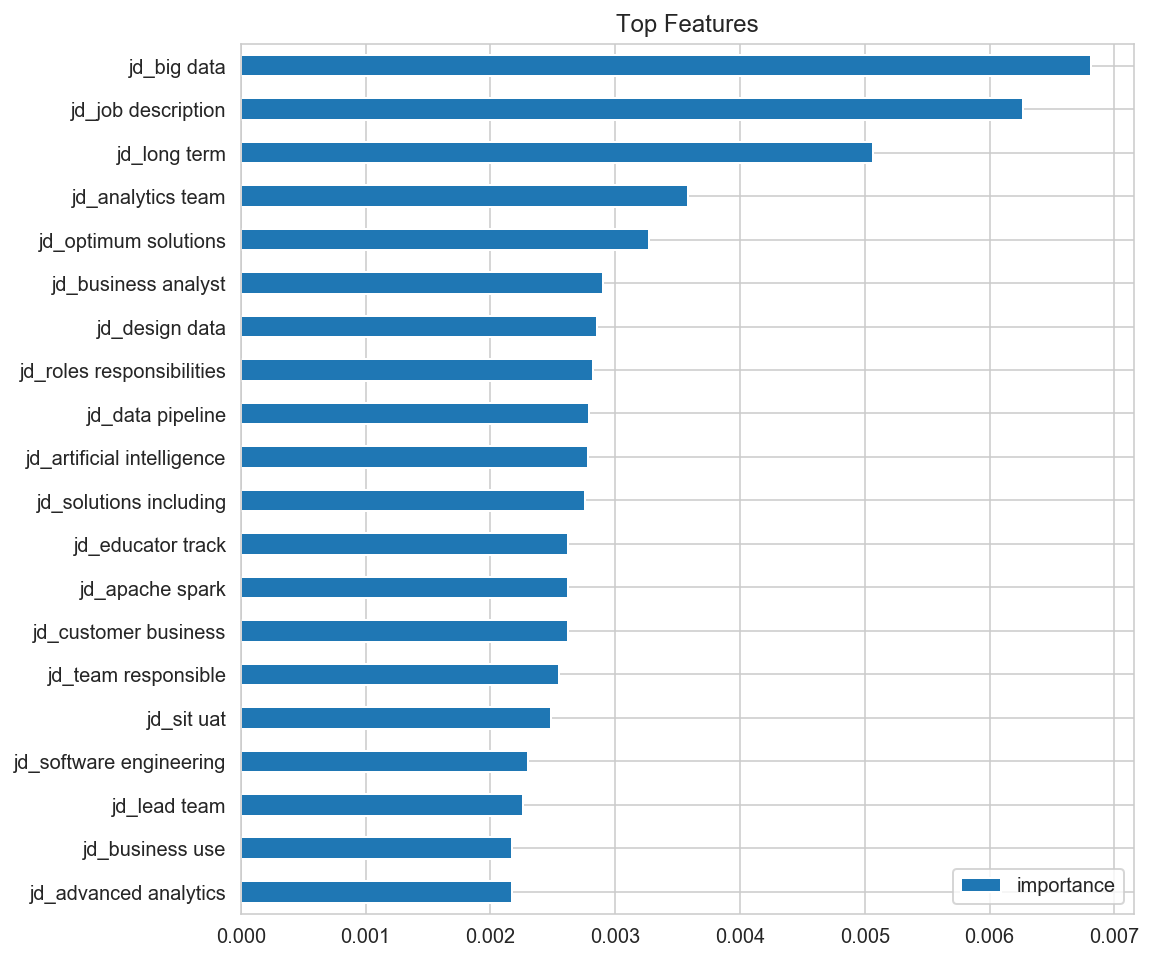

classification report:
             precision    recall  f1-score   support

 Low Salary       0.59      0.75      0.66       121
High Salary       0.65      0.47      0.54       117

avg / total       0.62      0.61      0.61       238

confusion matrix:
[[91 30]
 [62 55]]


In [86]:
results = results.append(benchmark(rf_clf, df_train_job_description_cv, y_train, df_test_job_description_cv, y_test, target_names_salary_class ,feature_description='Job Description'), ignore_index=True)

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=38, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)
train time: 0.863s
cross validation Score: 0.591 ± 0.077
test time:  0.027s
accuracy:   0.571
auc_roc score:   0.572
dimensionality: 10000
top 10 keywords per class:


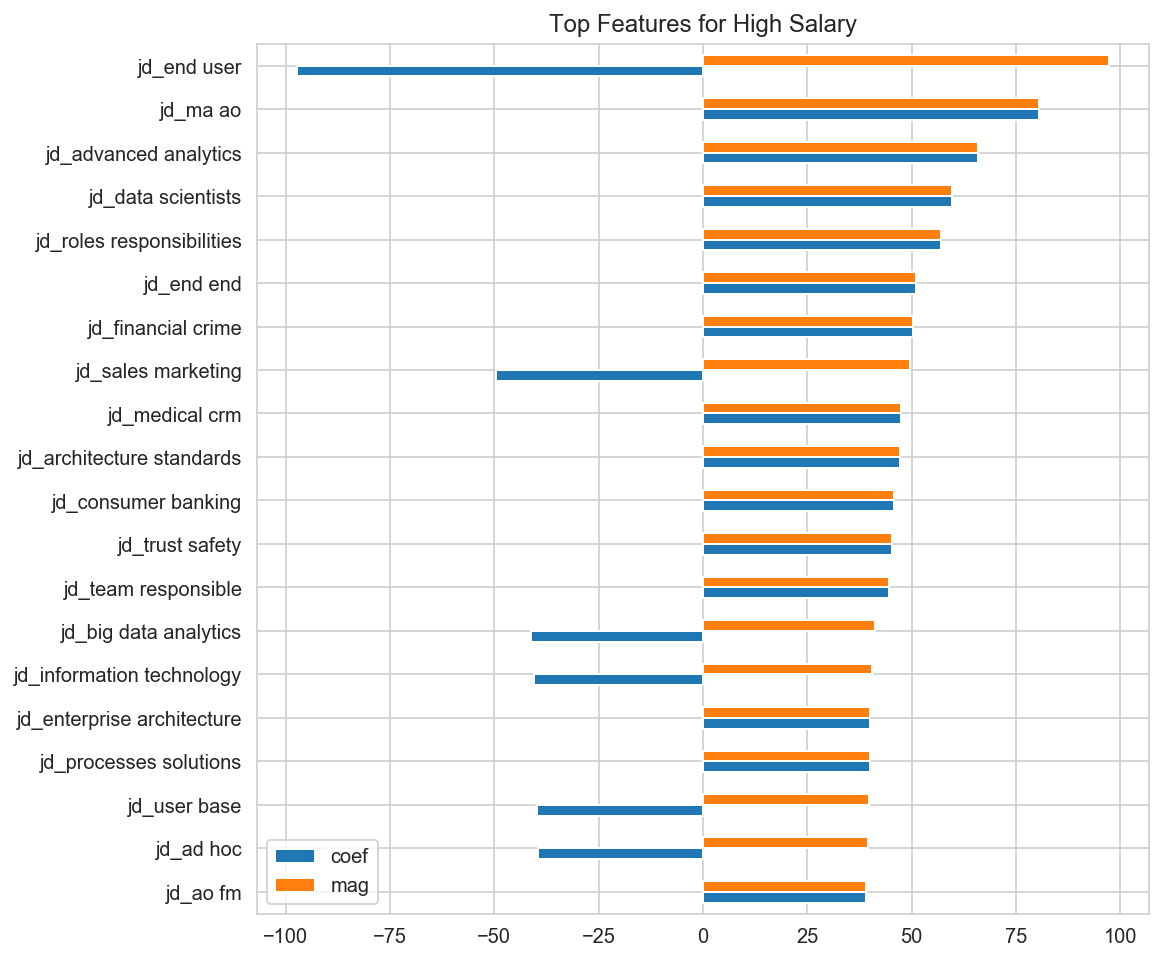

classification report:
             precision    recall  f1-score   support

 Low Salary       0.58      0.55      0.56       121
High Salary       0.56      0.60      0.58       117

avg / total       0.57      0.57      0.57       238

confusion matrix:
[[66 55]
 [47 70]]


In [87]:
results = results.append(benchmark(sgd_clf_l1, df_train_job_description_cv, y_train, df_test_job_description_cv, y_test, target_names_salary_class ,feature_description='Job Description'), ignore_index=True)

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=38,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
train time: 0.847s
cross validation Score: 0.594 ± 0.076
test time:  0.016s
accuracy:   0.559
auc_roc score:   0.561
dimensionality: 10000
top 10 keywords per class:


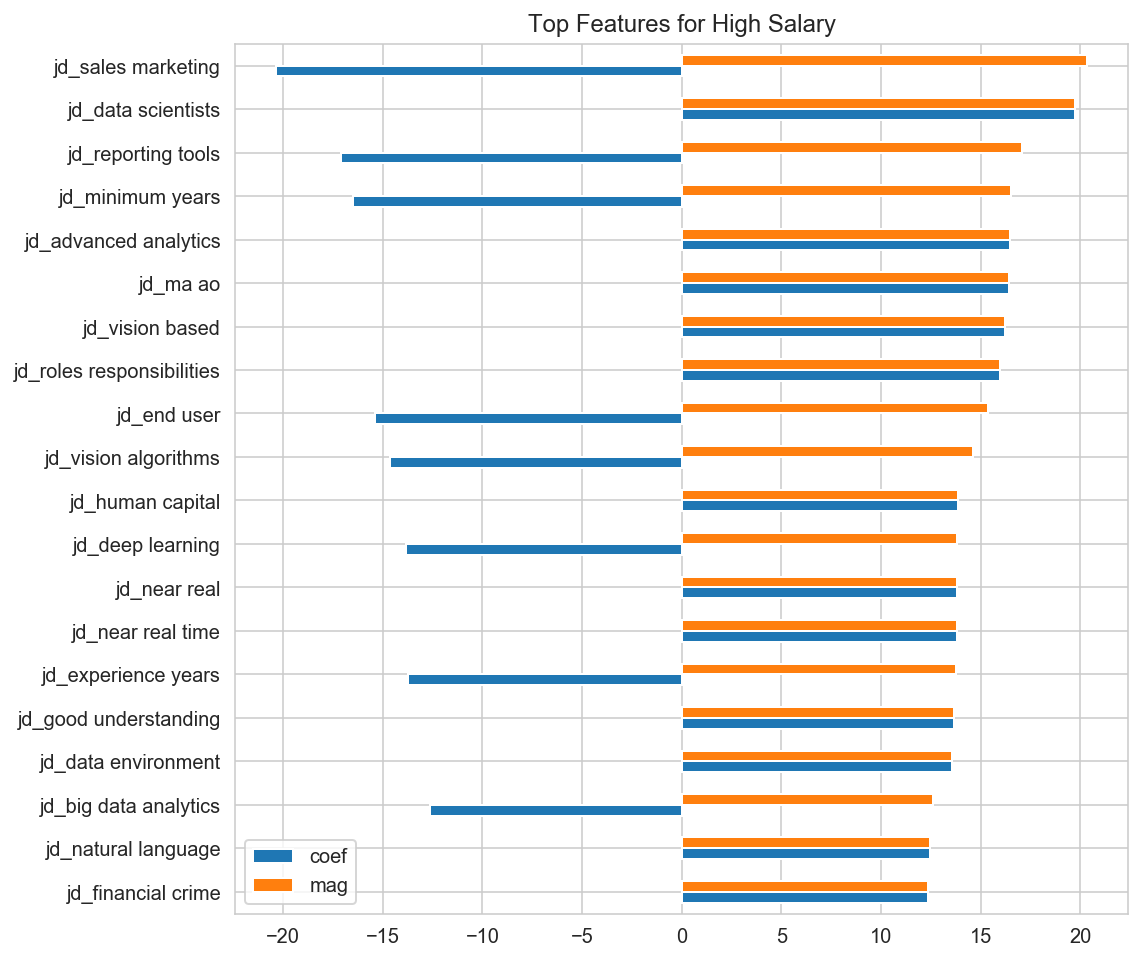

classification report:
             precision    recall  f1-score   support

 Low Salary       0.59      0.45      0.51       121
High Salary       0.54      0.68      0.60       117

avg / total       0.56      0.56      0.55       238

confusion matrix:
[[54 67]
 [38 79]]


In [88]:
results = results.append(benchmark(sgd_clf_elastic_net, df_train_job_description_cv, y_train, df_test_job_description_cv, y_test, target_names_salary_class ,feature_description='Job Description'), ignore_index=True)

<a id='salary_trends_train_test_jr'/>

#### Train and Test with features: 
- Job Requirements (prefix 'jr_')

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=38, verbose=0, warm_start=False)
train time: 3.607s
cross validation Score: 0.603 ± 0.057
test time:  0.031s
accuracy:   0.613
auc_roc score:   0.612


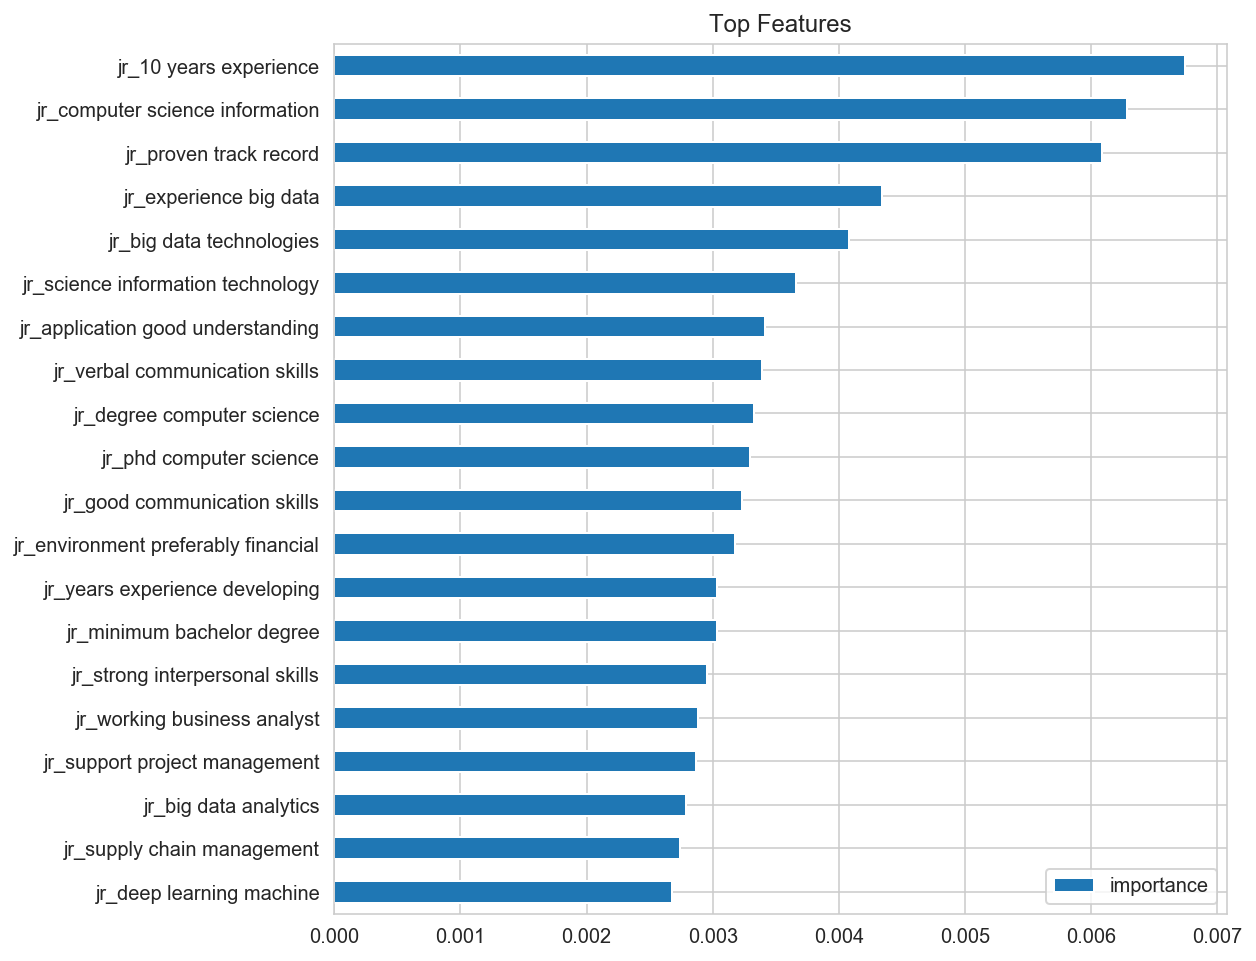

classification report:
             precision    recall  f1-score   support

 Low Salary       0.60      0.72      0.65       121
High Salary       0.63      0.50      0.56       117

avg / total       0.62      0.61      0.61       238

confusion matrix:
[[87 34]
 [58 59]]


In [90]:
results = results.append(benchmark(rf_clf, df_train_job_requirements_cv, y_train, df_test_job_requirements_cv, y_test, target_names_salary_class ,feature_description='Job Requirements'), ignore_index=True)

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=38, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)
train time: 0.693s
cross validation Score: 0.602 ± 0.061
test time:  0.000s
accuracy:   0.597
auc_roc score:   0.599
dimensionality: 7562
top 10 keywords per class:


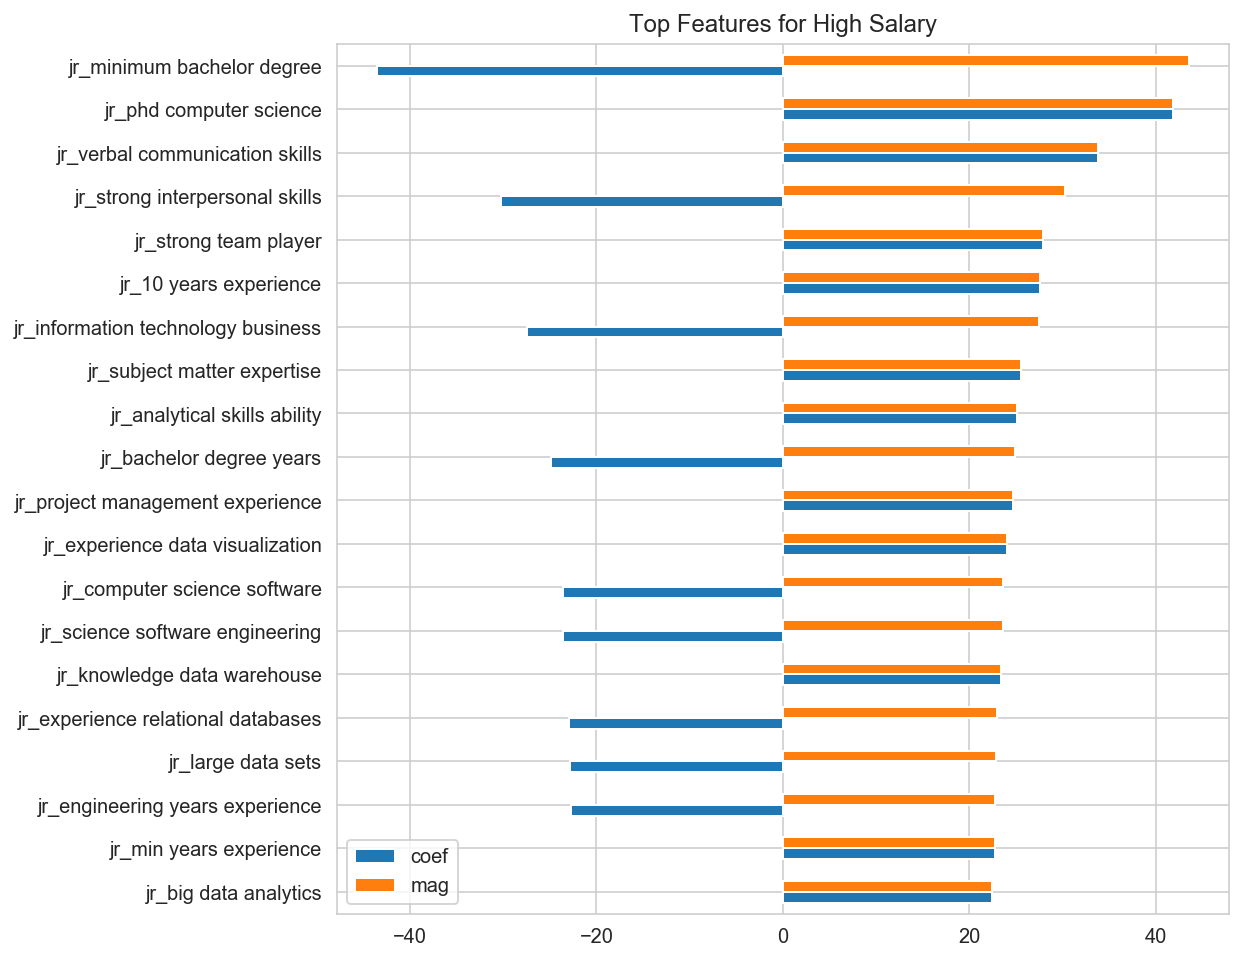

classification report:
             precision    recall  f1-score   support

 Low Salary       0.65      0.44      0.52       121
High Salary       0.57      0.76      0.65       117

avg / total       0.61      0.60      0.59       238

confusion matrix:
[[53 68]
 [28 89]]


In [91]:
results = results.append(benchmark(sgd_clf_l1, df_train_job_requirements_cv, y_train, df_test_job_requirements_cv, y_test, target_names_salary_class ,feature_description='Job Requirements'), ignore_index=True)

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=38,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
train time: 0.688s
cross validation Score: 0.61 ± 0.043
test time:  0.016s
accuracy:   0.576
auc_roc score:   0.579
dimensionality: 7562
top 10 keywords per class:


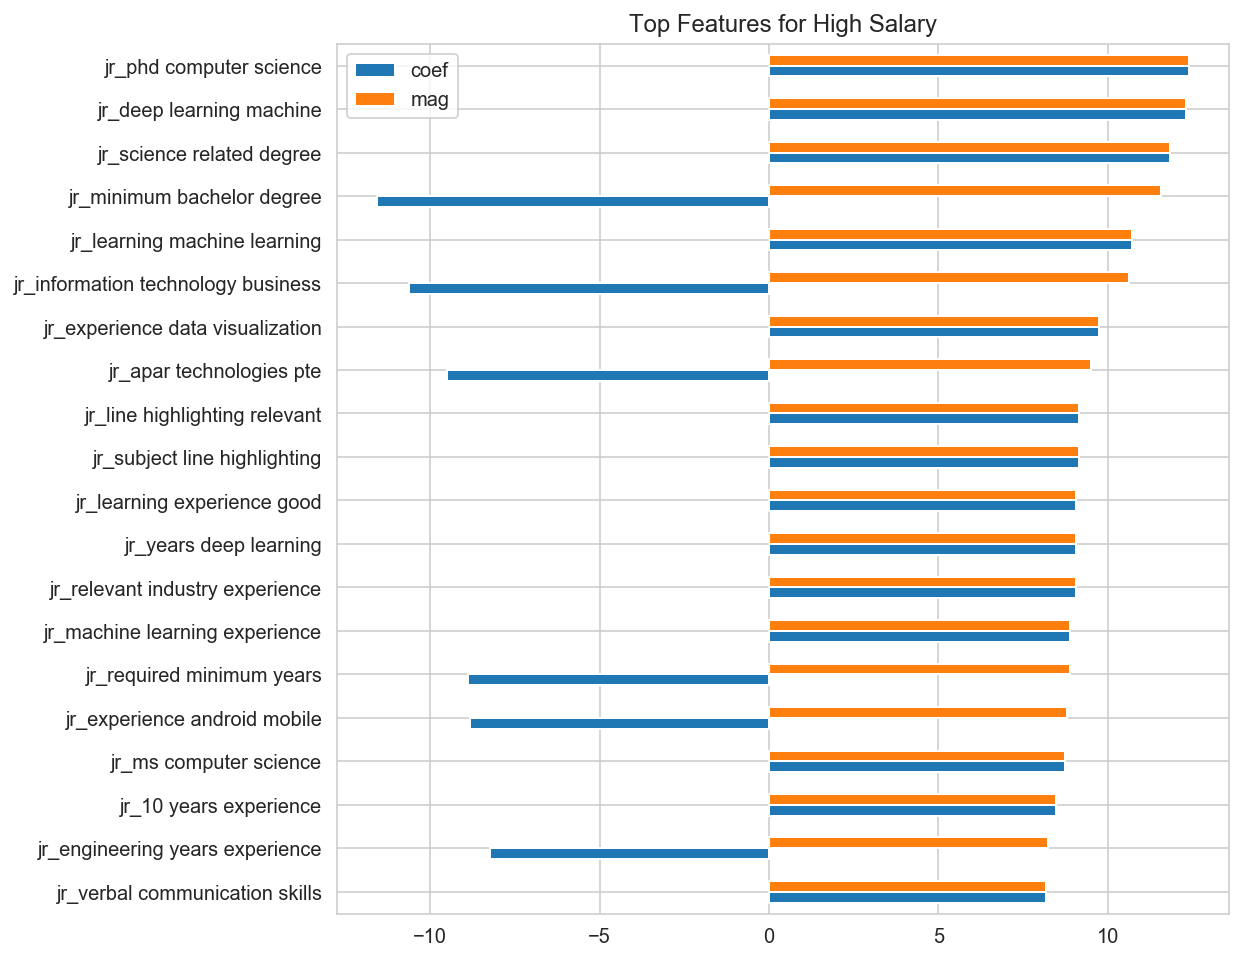

classification report:
             precision    recall  f1-score   support

 Low Salary       0.65      0.36      0.46       121
High Salary       0.55      0.80      0.65       117

avg / total       0.60      0.58      0.55       238

confusion matrix:
[[43 78]
 [23 94]]


In [92]:
results = results.append(benchmark(sgd_clf_elastic_net, df_train_job_requirements_cv, y_train, df_test_job_requirements_cv, y_test, target_names_salary_class ,feature_description='Job Requirements'), ignore_index=True)

One interesting observation is that based on the top coefficients in the above classifiers, jobs containing 'strong interpersonal skills' which by right is a desired skill, seem to guide towards lower salary class. Let's examine the related jobs in the dataset below.

In [93]:
# Let's take a look at jobs where job requirements contain 'strong interpersonal skills' 
df_train[df_train['job_requirements'].str.contains(r'(?i)strong interpersonal skills')]
# indeed most of the times these jobs belong in the lower salary class.

,job_title,job_company,job_location,job_seniority,job_industry,job_employment_type,job_salary_range_from,job_salary_range_to,job_salary_type,job_details_url,job_description,job_requirements,monthly_salary_avg,monthly_salary_class
302,APAC CRO Credit Risk Management Business Analy...,CREDIT SUISSE SERVICES AG,Central,Senior Executive,Banking and Finance,Permanent,9000.0,15000.0,Monthly,https://www.mycareersfuture.sg/job/apac-cro-cr...,credit suisse company overview credit suisse...,You Offer... \t You have a Bachelor's Degre...,12000.0,1
249,Business Analyst,SYSNET SYSTEM AND SOLUTIONS PTE. LTD.,West,Junior Executive,Information Technology,Full Time,3000.0,4500.0,Monthly,https://www.mycareersfuture.sg/job/business-an...,"\t gather, analyse and formalize users' busine...",Requirements: \t Degree or Diploma in Busi...,3750.0,0
530,Contract Business Management Analyst,Company Undisclosed,Central,Junior Executive,Insurance,Contract,3000.0,5000.0,Monthly,https://www.mycareersfuture.sg/job/contract-bu...,"position title : reports to : director, busi...","University degree, including Actuarial Science...",4000.0,0
569,Business Intelligence Manager,FOODPANDA SINGAPORE PTE. LTD.,Central,Manager,Information Technology,Full Time,4000.0,6000.0,Monthly,https://www.mycareersfuture.sg/job/business-in...,\t \t supporting the management in their anal...,"\t \t Outstanding degree in business, economi...",5000.0,0
371,Project Manager / Business Analyst,ADECCO PERSONNEL PTE LTD,Islandwide,Professional,Information Technology,Contract,6000.0,9000.0,Monthly,https://www.mycareersfuture.sg/job/project-man...,"\t responsible for business analysis, user coo...",\t Bachelor’s degree in Computer Science/ Engi...,7500.0,1
328,O&T - Technical Lead - 18046387,CITIBANK N.A.,East,Middle Management,Banking and Finance,Full Time,10000.0,17500.0,Monthly,https://www.mycareersfuture.sg/job/ot-technica...,\t key responsibilities of candidate will be s...,"\t 10+ year Experience in Java (Core EE,Spri...",13750.0,1
847,Integration Developer,WORKATO PTE. LTD.,South,Executive,Information Technology,Permanent,2000.0,10000.0,Monthly,https://www.mycareersfuture.sg/job/integration...,role workato is looking for s who are pas...,BA/BS or equivalent education - Computer degre...,6000.0,0
243,International Business Analyst,SCHNEIDER ELECTRIC IT LOGISTICS ASIA PACIFIC P...,East,Senior Executive,Consulting,Permanent,4500.0,8000.0,Monthly,https://www.mycareersfuture.sg/job/internation...,this position provides visibility to the busin...,\t University degree with focus on quantitativ...,6250.0,0
884,Quantitative Analyst,NIKKO ASSET MANAGEMENT ASIA LIMITED,Central,Freshentry level,Banking and Finance,Permanent,4000.0,4800.0,Monthly,https://www.mycareersfuture.sg/job/quantitativ...,\t provide quantitative support to the 16 ...,\t Very strong quantitative skills with knowle...,4400.0,0
89,Research Associate,SINGAPORE UNIVERSITY OF TECHNOLOGY AND DESIGN,East,Professional,Architecture Interior Design,Contract,4400.0,7260.0,Monthly,https://www.mycareersfuture.sg/job/research-as...,about the programme urban science as an emer...,Key Skills The candidate should \t hold a ...,5830.0,0


<a id='salary_trends_train_test_all'/>

#### Train and Test with all features: 
 - job_title
 - job_requirements
 - job_description
 - job_industry
 - job_seniority

In [94]:
X_train_all = pd.concat([df_train_job_title_cv,df_train_job_requirements_cv,df_train_job_description_cv,df_train_job_industry,df_train_job_seniority],axis=1)

In [97]:
X_test_all = pd.concat([df_test_job_title_cv,df_test_job_requirements_cv,df_test_job_description_cv,df_test_job_industry,df_test_job_seniority],axis=1)

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=38, verbose=0, warm_start=False)
train time: 3.335s
cross validation Score: 0.702 ± 0.036
test time:  0.128s
accuracy:   0.630
auc_roc score:   0.628


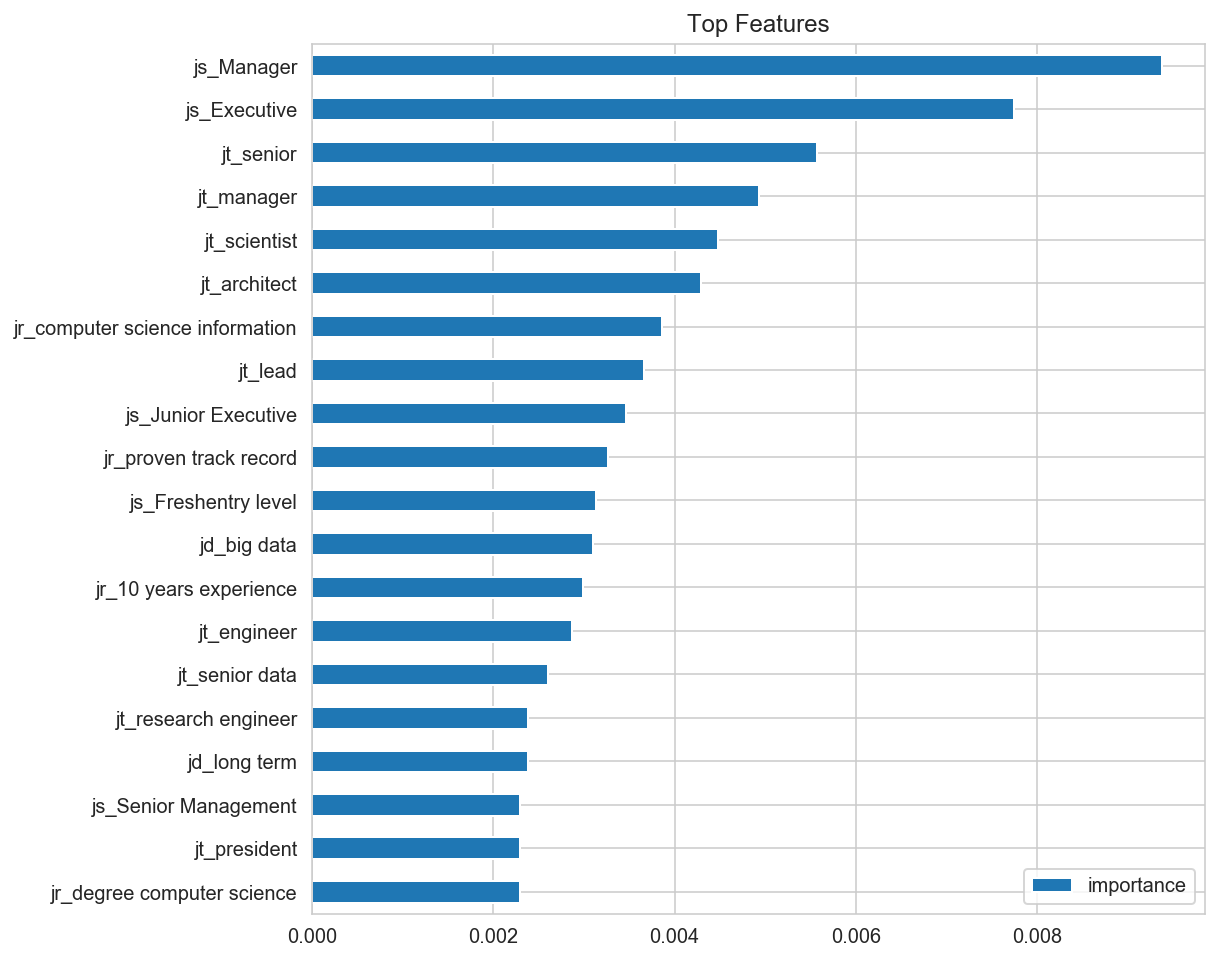

classification report:
             precision    recall  f1-score   support

 Low Salary       0.61      0.75      0.67       121
High Salary       0.66      0.50      0.57       117

avg / total       0.64      0.63      0.62       238

confusion matrix:
[[91 30]
 [58 59]]


In [98]:
results = results.append(benchmark(rf_clf, X_train_all, y_train, X_test_all, y_test, target_names_salary_class, feature_description='All'), ignore_index=True)

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=38, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)
train time: 1.311s
cross validation Score: 0.67 ± 0.061
test time:  0.063s
accuracy:   0.626
auc_roc score:   0.627
dimensionality: 18096
top 10 keywords per class:


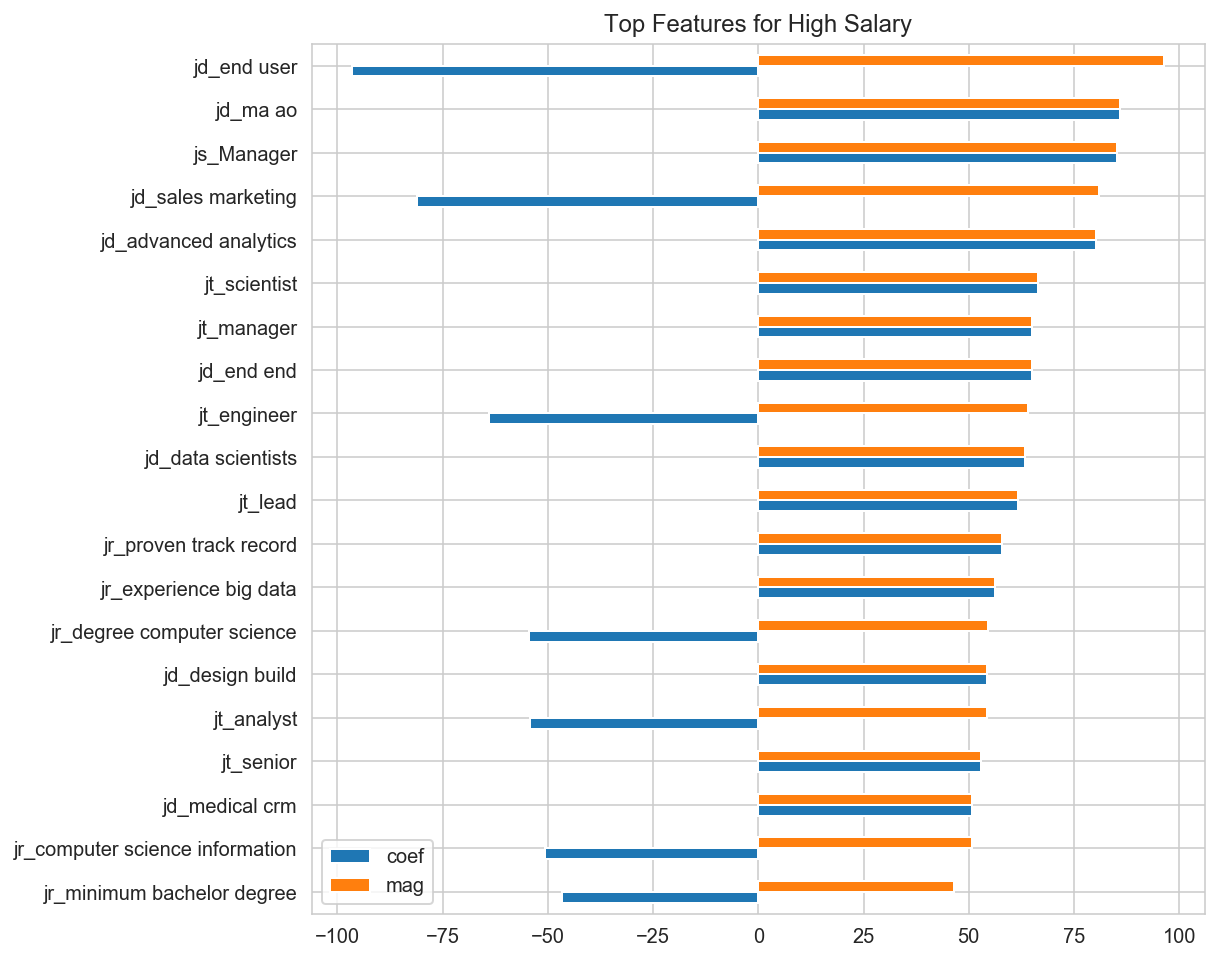

classification report:
             precision    recall  f1-score   support

 Low Salary       0.64      0.60      0.62       121
High Salary       0.61      0.66      0.63       117

avg / total       0.63      0.63      0.63       238

confusion matrix:
[[72 49]
 [40 77]]


In [99]:
results = results.append(benchmark(sgd_clf_l1, X_train_all, y_train, X_test_all, y_test, target_names_salary_class ,feature_description='All'), ignore_index=True)

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=38,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
train time: 1.736s
cross validation Score: 0.691 ± 0.033
test time:  0.062s
accuracy:   0.639
auc_roc score:   0.639
dimensionality: 18096
top 10 keywords per class:


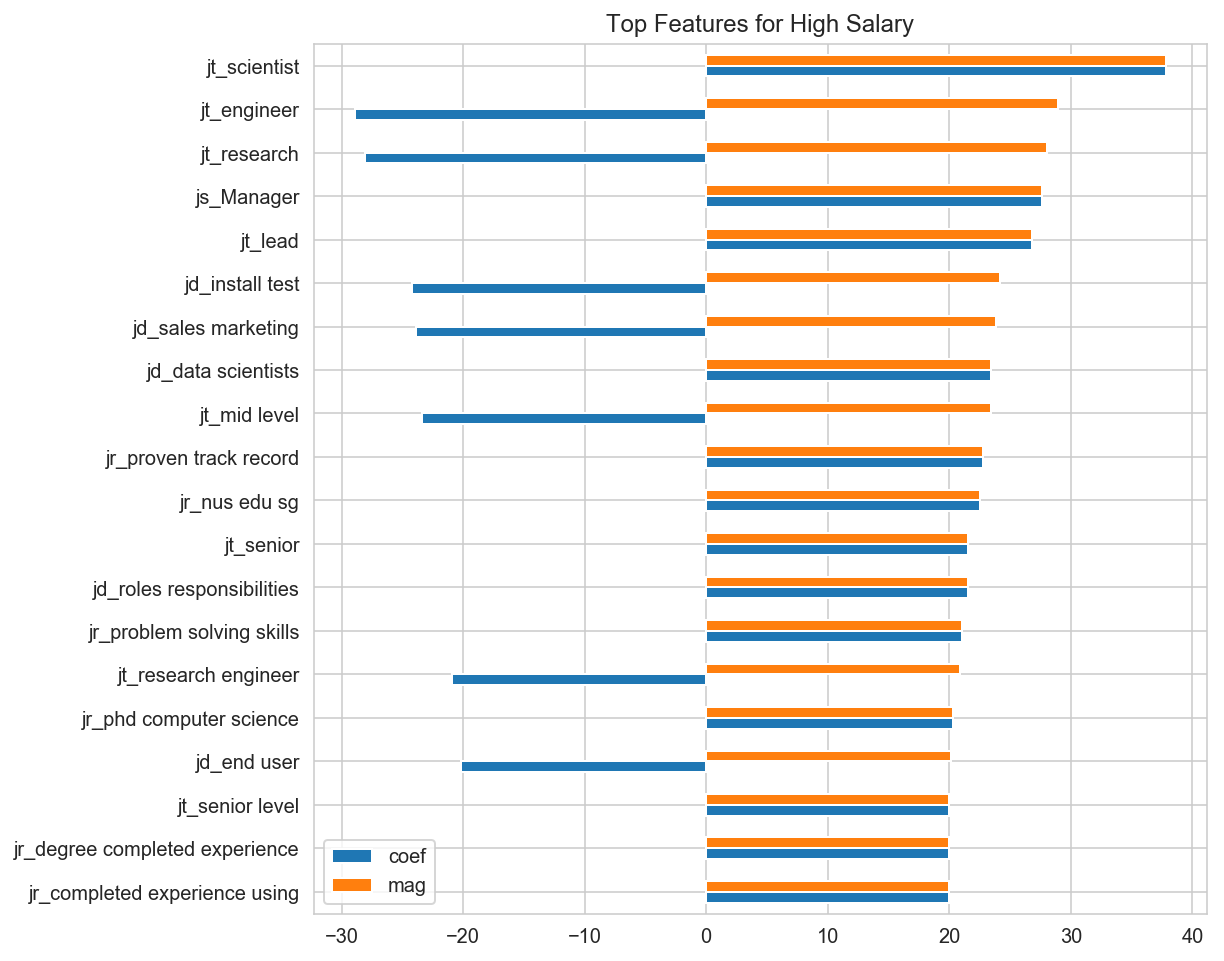

classification report:
             precision    recall  f1-score   support

 Low Salary       0.65      0.63      0.64       121
High Salary       0.63      0.65      0.64       117

avg / total       0.64      0.64      0.64       238

confusion matrix:
[[76 45]
 [41 76]]


In [100]:
results = results.append(benchmark(sgd_clf_elastic_net, X_train_all, y_train, X_test_all,y_test, target_names_salary_class ,feature_description='All'), ignore_index=True)

In [101]:
results

,Accuracy Score,Features Used,Model,ROC AUC Score
0,0.512605,Job Industry and Seniority,"SGDClassifier(alpha=0.0001, average=False, cla...",0.517129
1,0.634454,Job Industry and Seniority,"(DecisionTreeClassifier(class_weight=None, cri...",0.635693
2,0.512605,Job Industry and Seniority,"SGDClassifier(alpha=0.0001, average=False, cla...",0.517129
3,0.584034,Job Industry and Seniority,"SGDClassifier(alpha=0.0001, average=False, cla...",0.587942
4,0.642857,Job Title,"(DecisionTreeClassifier(class_weight=None, cri...",0.642262
5,0.626050,Job Title,"SGDClassifier(alpha=0.0001, average=False, cla...",0.623190
6,0.642857,Job Title,"SGDClassifier(alpha=0.0001, average=False, cla...",0.642827
7,0.613445,Job Description,"(DecisionTreeClassifier(class_weight=None, cri...",0.611076
8,0.571429,Job Description,"SGDClassifier(alpha=0.0001, average=False, cla...",0.571873
9,0.558824,Job Description,"SGDClassifier(alpha=0.0001, average=False, cla...",0.560747


#### From the above the highest scores is obtained when using all features on the model SGDClassifier with Elastic Net .  Plot the ROC curve for that model.
<a id='salary_trends_roc_curve'/>

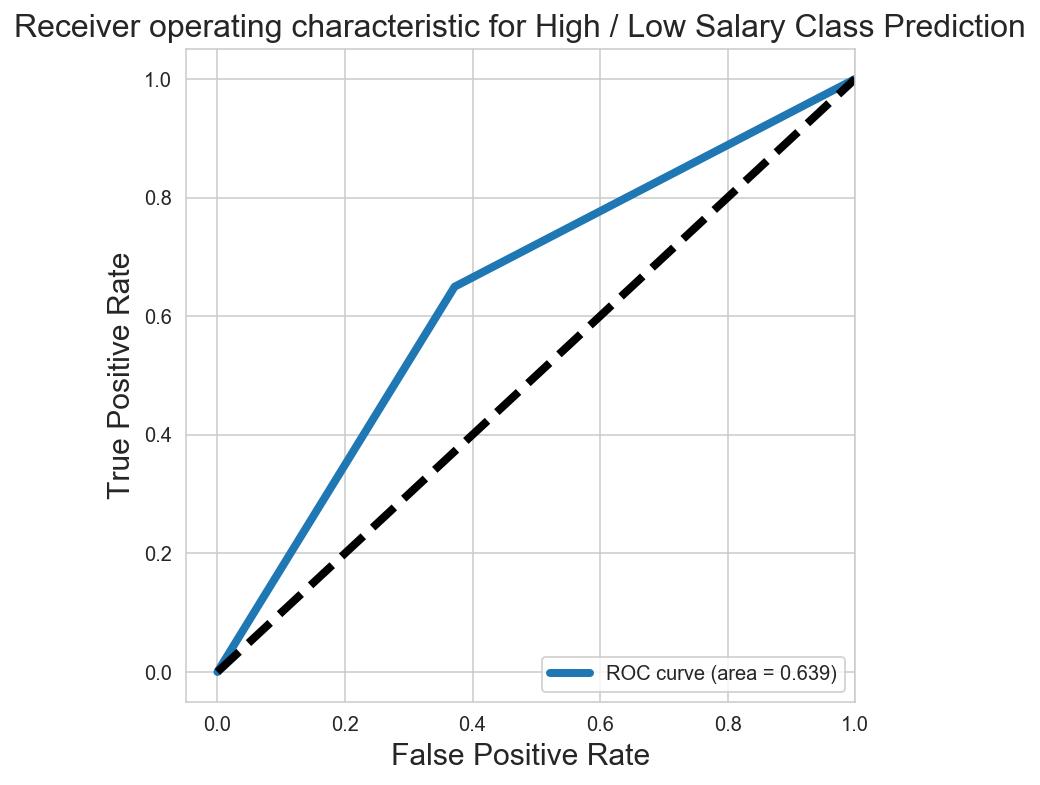

In [102]:
from sklearn.metrics import roc_curve, auc

# This best performing model happened to be last fitted on All training features so we can straightaway 
# use it to get predicted Y on All test features
fpr, tpr, _ = roc_curve(y_test, sgd_clf_elastic_net.predict(X_test_all))
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (has_cancer).
plt.figure(figsize=[6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver operating characteristic for High / Low Salary Class Prediction', fontsize=16)
plt.legend(loc="lower right")
plt.show()

<a id='job_category_factors'/>
## Section 2 Job Category Factors

### Let's examine the factors in the posting that distinguishes between 'data scientist', 'data analyst' and other job titles.

In [103]:
# Engineer the labels for 'data scientist' and data analyst'
indices_ds = df[df['job_title'].str.contains(r'(?i)data scientist')].index
indices_da = df[df['job_title'].str.contains(r'(?i)data analyst')].index

# verify that there is no intersection
print(set(indices_ds).intersection(indices_da)) 

set()


In [119]:
# Take a look at data scientist job titles 
df.loc[indices_ds,'job_title'].sample(15)

779                            Senior Data Scientist
79                                    Data Scientist
794                                   Data Scientist
666                                   Data Scientist
96        Data Scientist (Central / Leading Company)
823                                   Data Scientist
761                        Facilities Data Scientist
797                                   Data Scientist
595    FAC - GLOBAL FACILITIES SENIOR DATA SCIENTIST
758                                   Data Scientist
798                                   Data Scientist
190                                   Data Scientist
602                 Data Scientist 12 month contract
812                   Korean Speaking Data Scientist
5                                     Data Scientist
Name: job_title, dtype: object

In [105]:
# Take a look at data analyst job titles 
df.loc[indices_da,'job_title'].sample(15)

692                Data Analyst (1yr renewable contract)
651                                         Data Analyst
679                               Data Analyst (JD#4488)
653                                         Data Analyst
677                    Data Analyst (18 months contract)
632                                         Data Analyst
655    Data Analyst / Scientist (Tableau, SQL,Excel a...
690                             Data Analyst (Marketing)
641    VP  /  AVP, Data Analyst, Middle Office Techno...
635                                         Data Analyst
568                                         Data Analyst
633                                  Senior Data Analyst
659                                         Data Analyst
667                              Data Analyst, Marketing
537     Migration Data Business Analyst  /  Data Analyst
Name: job_title, dtype: object

In [106]:
# Proceed to label training data
# Engineer the labels for 'data scientist' and data analyst'
df['Job Category'] = 2  # label all as 'Others' first
df.loc[indices_ds,'Job Category'] = 0  # label Data Scientists
df.loc[indices_da,'Job Category'] = 1    # label Data Analysts

target_names_job_category = ['Data Scientist', 'Data Analyst', 'Others']

#### Baselines

In [107]:
# baseline in % for predicting Data Scientist
(len(indices_ds) / df.shape[0]) * 100 

7.481559536354057

In [108]:
# baseline in % for predicting Data Analyst
(len(indices_da) / df.shape[0]) * 100 

5.47945205479452

In [109]:
# baseline in % for predicting Others
((df.shape[0] - len(indices_da) - len(indices_ds)) / df.shape[0]) * 100 

87.03898840885142

In [110]:
# split the labels again into train test (follow the same split as Section 1 - Salary Trends)
y_train = df.loc[df_train_indices,'Job Category']
y_test = df.loc[df_test_indices,'Job Category']

<a id='job_category_factors_train_test'/>
#### Train and Test with all features except Job Title: 
 - job_requirements
 - job_description
 - job_industry
 - job_seniority

In [111]:
X_train_jr_jd_ji_js = pd.concat([df_train_job_requirements_cv,df_train_job_description_cv,df_train_job_industry,df_train_job_seniority],axis=1)

In [112]:
X_test_jr_jd_ji_js = pd.concat([df_test_job_requirements_cv,df_test_job_description_cv,df_test_job_industry,df_test_job_seniority],axis=1)

In [113]:
results_job_category = pd.DataFrame()

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=38, verbose=0, warm_start=False)
train time: 2.409s
cross validation Score: 0.873 ± 0.01
test time:  0.078s
accuracy:   0.870


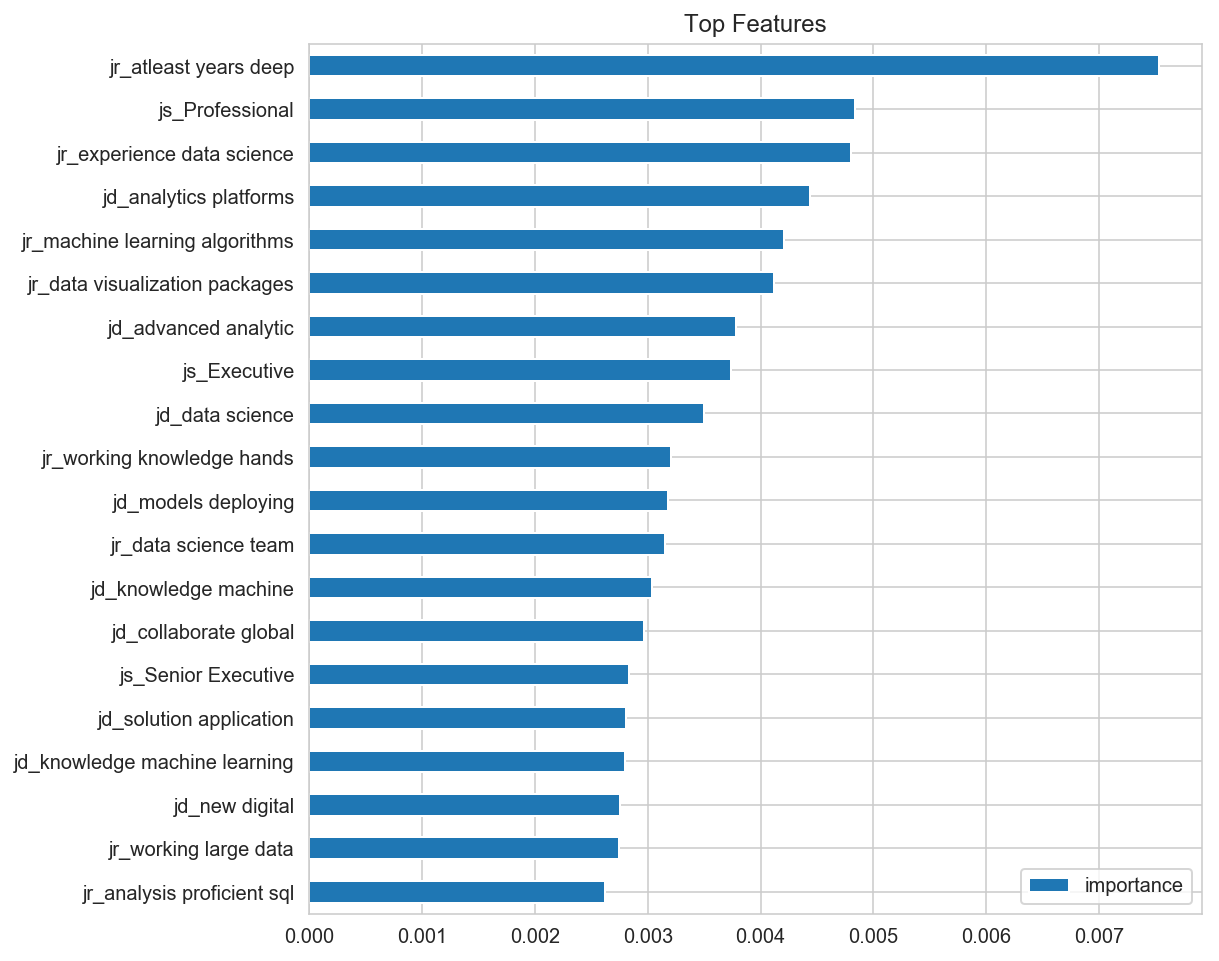

classification report:
                precision    recall  f1-score   support

Data Scientist       1.00      0.23      0.37        22
  Data Analyst       0.20      0.08      0.12        12
        Others       0.88      0.99      0.93       204

   avg / total       0.86      0.87      0.84       238

confusion matrix:
[[  5   1  16]
 [  0   1  11]
 [  0   3 201]]


In [115]:
results_job_category = results.append(benchmark(rf_clf, X_train_jr_jd_ji_js, y_train, X_test_jr_jd_ji_js, y_test, target_names_job_category, 'All'), ignore_index=True)

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=38,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
train time: 1.845s
cross validation Score: 0.871 ± 0.018
test time:  0.075s
accuracy:   0.870
dimensionality: 17597
top 10 keywords per class:


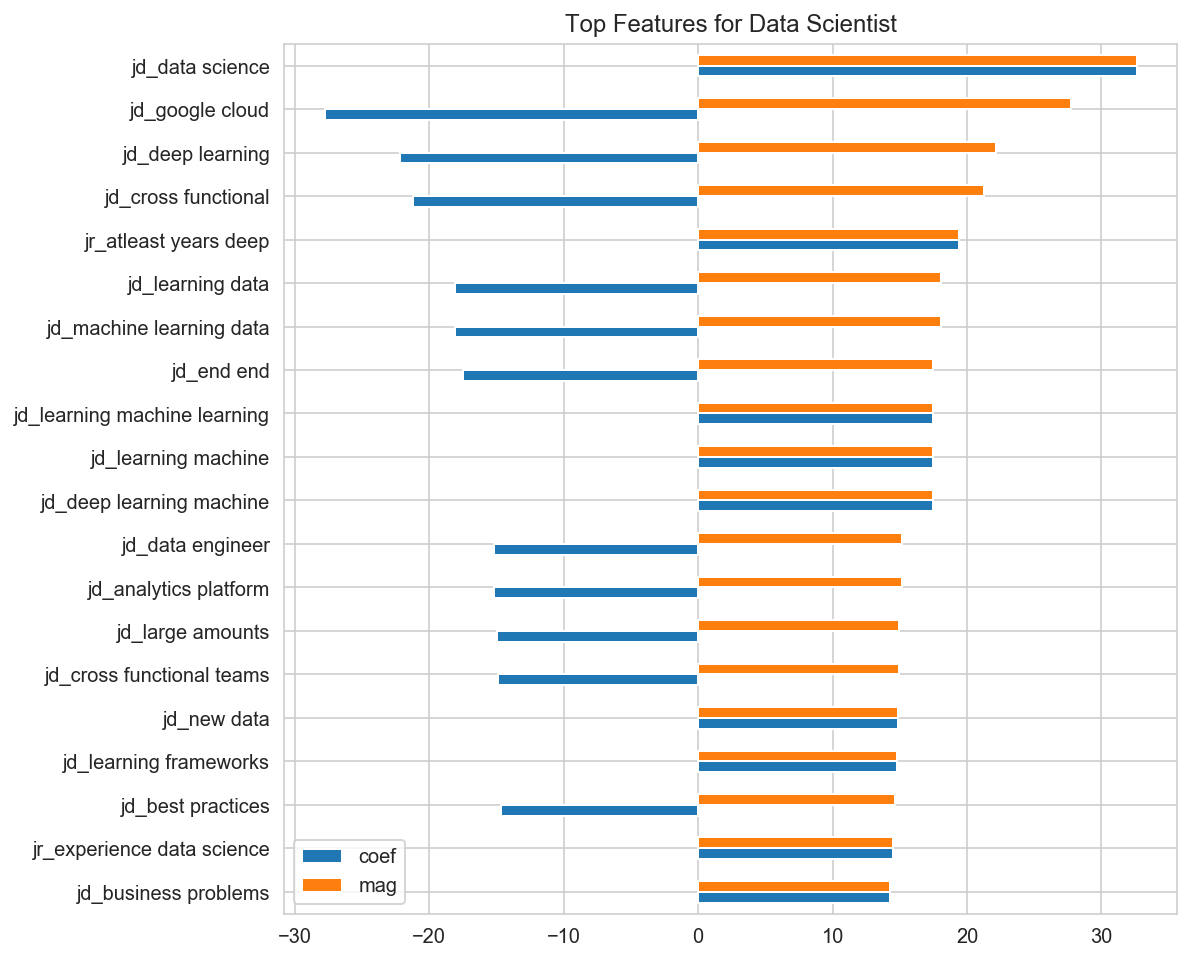

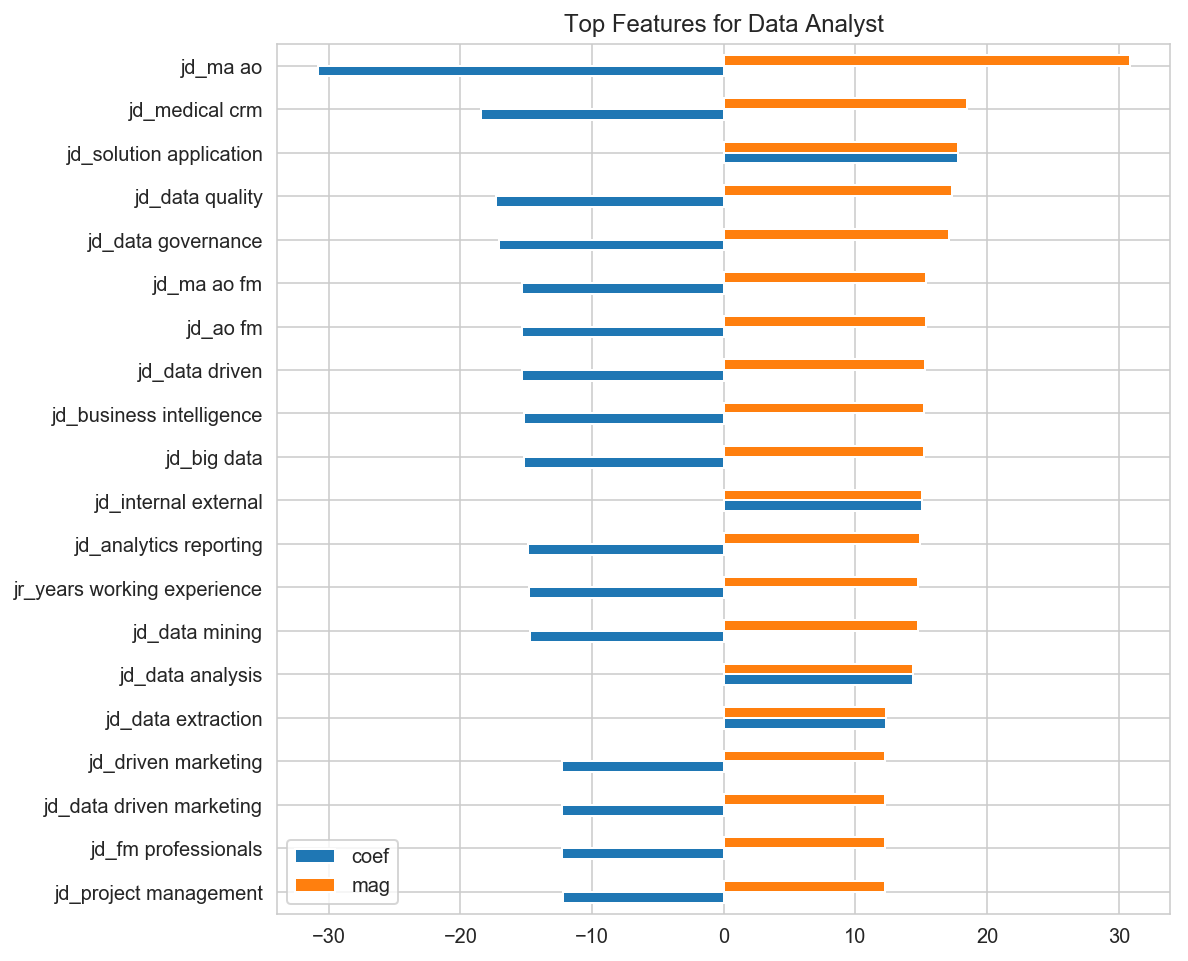

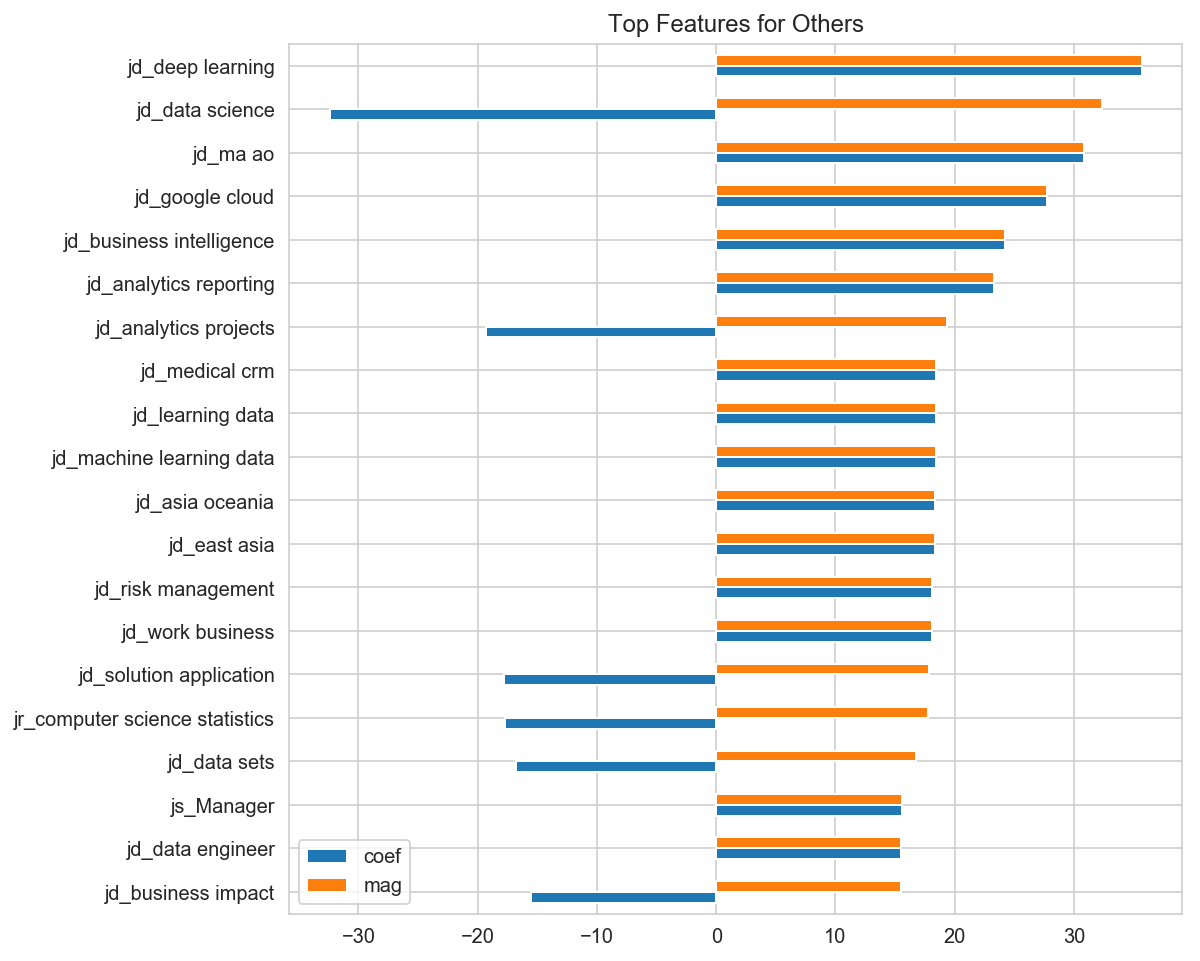

classification report:
                precision    recall  f1-score   support

Data Scientist       0.67      0.45      0.54        22
  Data Analyst       0.29      0.17      0.21        12
        Others       0.90      0.96      0.93       204

   avg / total       0.85      0.87      0.86       238

confusion matrix:
[[ 10   1  11]
 [  0   2  10]
 [  5   4 195]]


In [123]:
results_job_category = results.append(benchmark(sgd_clf_elastic_net, X_train_jr_jd_ji_js, y_train, X_test_jr_jd_ji_js, y_test, target_names_job_category, 'All'), ignore_index=True)

For both Random Forest and Stochastic Gradient Descent (SGD) Models the accuracies for classifying a job specifically as 'Data Scientist' or 'Data Analyst' vs 'Others' are not high, however the performances look satisfactory as the former two are highly under-represented classes.

In general the SGD has better balance of both precision and recall (f1 score) compared to the Random Forest model.

Will highlight the important features in the Executive Summary.

<a id='executive_summary'/>

# Executive Summary: Analysis of Data-Related Jobs

Dataset: Scraped from www.mycareerfuture.com.sg on 30 Oct 2018 - 949 rows of 12 columns.

## Section 1 Job Salary Trends

### Monthly Salary by Industry

![salary_by_industry](project4_sal_by_industry.png "Title")

- The highest average data-related salaries is shown to be in Accounting / Auditing / Taxation and Telecommunications.
- But some of the data may not be representative because the number of jobs represented in most industries are very limited.
- The most well represented industries are (1) IT, (2) Banking / Finance and (3) Engineering (highest count), hence the average salary figures for those sectors may be more reliable.

### High vs Low Salary

Median salary is $6,750.00 .
We classify Salary into 2 classes: **High Salary Class** if above median, **Low Salary Class** otherwise.

### Probability of High Salary Class by Industry 

- Again, review the reliability of the indicated probability with the number of jobs represented per industry in the previous chart.
- Some of the data may not be representative because the number of jobs represented in most industries are very limited. 
- The most represented industries are (1) IT, (2) Banking / Finance and (3) Engineering (highest count), hence the probabilities for those sectors may be more reliable.

![salary_proba_by_industry](project4_sal_proba_by_industry.png "Title")

### Probability of High Salary Class by Seniority

 - It seems either 'Manager' or 'Management' terms in Job Seniority gives a higher chance of high salary, followed by 'Professional' and 'Senior'.
 - The interesting observation is that non-executives have a higher probability of getting higher salary than 'Executives'!  This may be due to a non-disriminatory usage of the term 'Executive'.
 - As expected 'Junior Executive' has high probability of getting lower salary, but unexpectedly that is even higher than Fresh / Entry level.

![salary_by_seniority](project4_sal_by_seniority.png "Title")

### Top features for High vs Low Salary Class

Top factors from postings that incline a job towards

**High Salary Class**
- Job Title includes terms 
    - 'scientist' or 
    - 'lead'
    - 'senior'
- Job Seniority includes terms 
    - 'manager'
- Job Description includes terms 
    - 'data scientists'
    - 'problem solving skills'
    - 'phd cimputer science'
- Job Requirements include terms
    - 'proven track record'
    - 'nus edu sg'

**Low Salary Class**
- Job Title includes terms
    - 'engineer', 
    - 'research'
- Job Description includes terms
    - 'install test'
    - 'sales marketing'
    - 'end user'
- Job Title includes terms
    - 'mid level'


## Section 2 Job Category Factors

### Top features for Data Scientist

Interpretation of the below output from the model - top factors from postings that incline a job towards the categories:

**Data Scientist**
- Job Description includes terms 
    - 'data science' 
    - 'machine learning'
    - 'deep learning machine'
    - 'new data'
    - 'learning frameworks'
    - 'experience data science'
    - 'busines problems'
- Job Requirements includes terms 
    - 'at least x years in deep'

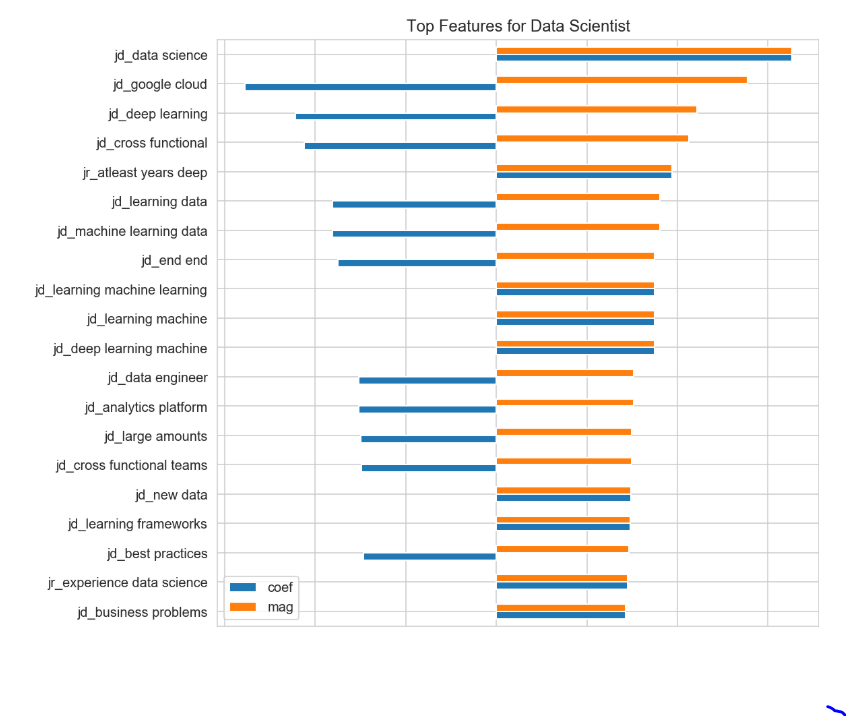


Future Enhancements: 
    - Try out train test split with stratify option to see if accuracy improves.